In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from scipy.stats import norm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix, brier_score_loss
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Function for creating direct forecast DataFrame
def makeDirFcastDf2(df, p_lags0,p_lags1,p_lags2, q_lags, s_lags, target):
    new_df = pd.DataFrame()
    col = df.columns
    for h in range(1,13):
        new_df[f'{target}_0']=df[target]
        new_df[f'{target}_{h}']=df[target].shift(periods=-h)
    
        if q_lags == 0:
            pass
        elif q_lags == 1:
            new_df[f'{target}_lag_0']=df[target]
        elif q_lags >= 2:
            for q in range(1,q_lags):
                new_df[f'{target}_lag_0']=df[target]
                new_df[f'{target}_lag_{q}']=df[target].shift(periods=q)
        
        if p_lags0 == 0:
            pass
        elif p_lags0 == 1:
            new_df[f'{col[0]}_lag_0']=df[col[0]]
        elif p_lags0 >= 2:
            for p0 in range(1,p_lags0):
                new_df[f'{col[0]}_lag_0']=df[col[0]]
                new_df[f'{col[0]}_lag_{p0}']=df[col[0]].shift(periods=p0)
        
        if p_lags1 == 0:
            pass
        elif p_lags1 == 1:
            new_df[f'{col[1]}_lag_0']=df[col[1]]
        elif p_lags1 >= 2:
            for p1 in range(1,p_lags1):
                new_df[f'{col[1]}_lag_0']=df[col[1]]
                new_df[f'{col[1]}_lag_{p1}']=df[col[1]].shift(periods=p1)
        
        if p_lags2 == 0:
            pass
        elif p_lags2 == 1:
            new_df[f'{col[2]}_lag_0']=df[col[2]]
        elif p_lags2 >= 2:
            for p2 in range(1,p_lags2):
                new_df[f'{col[2]}_lag_0']=df[col[2]]
                new_df[f'{col[2]}_lag_{p2}']=df[col[2]].shift(periods=p2)
#         
        
        if s_lags == 1:
            new_df[f'{col[-1]}_lag_0']=df[col[-1]]
        elif s_lags >= 2:
            for s in range(1,s_lags):
                new_df[f'{col[-1]}_lag_0']=df[col[-1]]
                new_df[f'{col[-1]}_lag_{s}']=df[col[-1]].shift(periods=s)
    return new_df.dropna()


#Function for spliting data in to training and test set DataFrame
def fcast_train_testDF1(df, p_order0,p_order1,p_order2,q_order, target_var, s_lags, f_horizon=None):
    newdf1 = makeDirFcastDf2(df,p_order0,p_order1,p_order2,q_order,s_lags, target_var)

    useDF1 = newdf1.loc[:,[l for l in newdf1.columns if 'lag' in l]]
    useDF1[f'{target_var}_{f_horizon}'] = newdf1[f'{target_var}_{f_horizon}']


    train_Df = useDF1.iloc[:830,:]
    test_Df = useDF1.iloc[830:,:]
    X_train = train_Df.iloc[:,:]
    y_train = train_Df.loc[:,f'{target_var}_{f_horizon}']
    X_test = test_Df.iloc[:,:]
    y_test = test_Df.loc[:,f'{target_var}_{f_horizon}']

    return X_train, X_test, y_train, y_test

def fcast_train_testDF_AR(df, p_order0,p_order1,p_order2,q_order, target_var, s_lags, f_horizon=None):
    newdf1 = makeDirFcastDf2(df,p_order0,p_order1,p_order2,q_order,s_lags, target_var)
    useDF1 = newdf1.loc[:,[l for l in newdf1.columns if 'lag' in l]]
    useDF1[f'{target_var}_{f_horizon}'] = newdf1[f'{target_var}_{f_horizon}']

    train_Df = useDF1.iloc[:,:]

    
    X_train = train_Df.iloc[:,:]
    
    y_train = train_Df.loc[:,f'{target_var}_{f_horizon}']

    return X_train, y_train


def scaleValuesV(df):
    sdf = df.iloc[:,:-2]
    sdf1 = (sdf-sdf.mean())/sdf.std()
    sdf1['VCI'] = (df.VCI/100 - np.mean(df.VCI.values/100))
    sdf1['Season'] = df.Season
    
    return sdf1, np.mean(df.VCI.values/100)


def addSeason(_df):
    df2 = _df
    df2 = df2.set_index('Date')

    df2['Month'] = df2.index.month

    jf = df2[(df2.Month>=1) & (df2.Month<=2)]
    jf['Season']  = 'jf'
    mam = df2[(df2.Month>=3) & (df2.Month<=7)]
    mam['Season']  = 'mam'
    jja = df2[(df2.Month>=8) & (df2.Month<=9)]
    jja['Season']  = 'jja'
    ond = df2[(df2.Month>=10) & (df2.Month<=12)]
    ond['Season']  = 'ond'
    new_sdf = pd.concat([jf, mam, jja, ond])
    new_sdf = new_sdf.sort_values(by='Date')
    return new_sdf.reset_index(drop=True)

In [221]:
county0 = [
'Tharaka-Nithi',
'Turkana',
'Taita-Taveta',
'Kajiado',
'Laikipia',
'Tana-River',
'Garissa',
'Narok',
'Embu',
'Mandera',
'Kitui',
'Wajir',
'West-Pokot',
'Isiolo',
'Kilifi',
'Meru',
'Nyeri',
'Baringo',
'Makueni',
'Samburu',
'Marsabit'
]

county1 = [
'Tharaka-Nithi',
'Turkana',
'Taita-Taveta',
'Kajiado',
'Laikipia',
'Tana-River',
'Garissa',
'Narok',
'Mandera',
'Kitui',
'Wajir',
'West-Pokot',
'Isiolo',
'Kilifi',
'Meru',
'Nyeri',
'Baringo',
'Makueni',
'Samburu',
'Marsabit'
]



county1_sarid = [
'Tharaka-Nithi',
'Taita-Taveta',
'Kajiado',
'Laikipia',
'Narok',
'Kitui',
'West-Pokot',
'Kilifi',
'Meru',
'Nyeri',
'Baringo',
'Makueni',
]

county1_arid = [
'Turkana',
'Tana-River',
'Garissa',
'Mandera',
'Wajir',
'Isiolo',
'Samburu',
'Marsabit'
]

In [17]:
# Function for plotting ROC Curve
def plotROC(df, name, data):
    FPs,FNs,TPs,TNs = [],[],[],[]
    FPR,TPR = [],[]
    Hor = []

    fig,ax1 = plt.subplots(figsize=(8,8))


#     ax1.set_prop_cycle(plt.cycler('color', ['black', '#1f77b4', '#ff7f0e', '#2ca02c','#d62728' ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#74bfe8']]))
    ax1.set_prop_cycle(plt.cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728']))

    AreaPerWeek = []
    something = 0 

    HWeeks=[4,6,8,10,12]
    for hweek in HWeeks:
        fhor = df[(df['Horizon']==hweek)]
        if data == 'VCI':
            forecast = fhor.VCI_Forecast.values*100
            actual  = fhor.VCI_Observed.values*100
        elif data == 'NDVI':
            forecast = fhor.VCI_Predicted.values
            actual  = fhor.VCI_Observed.values

    #     mask = np.isnan(forecast)

    #     actual = actual[~mask]

    #     forecast = forecast[~mask]
    #     dates = np.array(dates)[~mask]


        FPR,TPR = [],[]
        Hor.append(np.repeat(hweek, len(actual)))

        for VCI in range(0,len(actual)):

                FP,FN,TP,TN = 0,0,0,0

                for item,item2 in zip(actual,forecast): 

                    if item < VCI and item2 <35:
                        TP +=1
                    elif item < VCI and item2 > 35:
                        FP +=1
                    elif item > VCI and item2 < 35:
                        FN +=1
                    elif item > VCI and item2 >35:
                        TN +=1

                FPs.append(FP)
                FNs.append(FN)
                TPs.append(TP)
                TNs.append(TN)
               

                try:
                    TPR.append(TP/(TP+FN))
                except:
                    TPR.append(1)

                try:
                    FPR.append(FP/(FP+TN)) 
                except:
                    FPR.append(0)
                
                if VCI == 35:
                    if something == 0:
                        try:
                            ax1.scatter(FP/(FP+TN),TP/(TP+FN),s=45,label = ('VCI < 35'))    
                            something +=1
                        except:
                            something +=1
                    else:
                        try:
                            ax1.scatter(FP/(FP+TN),TP/(TP+FN),s=45)    
                        except:
                            print('Name')
          
        AUC = np.trapz(TPR,FPR,dx=0.001)        
        ax1.plot(FPR,TPR,label='{} Week forcast time \nAUC = {}'.format(hweek,round(AUC,2)))
            #ax1.plot(FPR,TPR,label =('Week' + str(weeks)+ '\nAUC = ' +str(np.round(AUC,2))))

        AreaPerWeek.append(AUC)


        yx = np.linspace(0,1,10)
        ax1.plot(yx,yx,dashes=[6, 2],color='black')

        ax1.set_xlim(0,1)
        ax1.set_ylim(0,1)
        ax1.legend(fontsize=13)
        ax1.grid(True)
        ax1.set_title(f'ROC {name}')
        ax1.set_ylabel('True Positive Rate', fontsize=13)
        ax1.set_xlabel('False Positive Rate', fontsize=13)
        plt.savefig(f'ROC-{name}.pdf',dpi=400)
        
    #     plt.savefig('{}{}.pdf'.format(file_path,key),dpi=400)
    #     plt.show()
        print(np.array(AreaPerWeek)*100)
        
        pd.DataFrame({'TPR':TPR, 'FPR':FPR}).to_csv(f'ROC_Metrics_{name}_{hweek}.csv')

In [18]:
# Funtion to compute PICP and MPIW (BARDL)
def getPICI_BARDL(obsarr, farr):
    PICP = []
    MPIW = []
    for i in np.arange(farr.shape[1]):
        p_upper = np.percentile(farr, 100, axis=0)
        p_lower = np.percentile(farr, 5, axis=0)
        ci = []
        for i in range(len(p_upper)):
            c = p_lower[i] <= obsarr[i] and obsarr[i] <= p_upper[i]
            if c == True:
                ci.append(1)
            else:
                ci.append(0)
        PICP.append(sum(ci)/len(p_upper))
        MPIW.append(sum(p_upper-p_lower)/len(p_upper))
    return np.array(PICP), np.array(MPIW)
# Funtion to compute PICP and MPIW (AR)
def getPICI_AR(observed, upper, lower):
    p_upper = upper
    p_lower = lower
    ci = []
    for i in range(len(p_upper)):
        c = p_lower[i] <= observed[i] and observed[i] <= p_upper[i]
        if c == True:
            ci.append(1)
        else:
            pass
    return sum(ci)/len(p_upper), sum(p_upper-p_lower)/len(p_upper)

In [19]:
def joinDf(dflist): # Join the tables from BARDL cross validation
    VCIO_ls = []
    for v in dflist:
        VCIO_ls.append(pd.read_csv(v))
    return pd.concat(VCIO_ls)

def getMetricts(df): # Compute model evaluation metrics (R2, RMSE, etc) BARDL cross validation
    metrics_ls0 = []
    for c in df.County.unique():
        sub_county = df[df.County==c]
        for h in [4,6,8,10,12]:
            hor = sub_county[sub_county['Horizon']==h]
            corr = np.corrcoef(hor.VCI_Observed.values, hor.VCI_Forecast.values)
            mae2 = mean_absolute_error(hor.VCI_Observed.values, hor.VCI_Forecast.values)
            rmse2 = np.sqrt(mean_squared_error(hor.VCI_Observed.values, hor.VCI_Forecast.values))
            r2 = r2_score(hor.VCI_Observed.values, hor.VCI_Forecast.values)
            metrics_ls0.append(pd.DataFrame({'County':[c], 'Horizon':[h], 'R2':[r2], 'MAE':[mae2], 'RMSE':[rmse2]}))
    return pd.concat(metrics_ls0)

def getAsalTables(meticsDf): # Create the metrics table to Arid and Semiarid Region 
    metrics = getMetricts(meticsDf)
    metrics = metrics[metrics.R2>0]
    metrics = metrics.loc[:,['County', 'Horizon', 'R2']]
    metrics0 = metrics.pivot_table(index=['County'], columns=['Horizon'], values=['R2']).reset_index()
    metrics0.columns = ['County', 4,6,8,10,12]
    metrics_arid = metrics0.loc[metrics0['County'].isin(county1_arid)].set_index('County')
    metrics_arid.loc['Mean'] = metrics_arid.mean(axis=0)
    metrics_arid.loc['Std. Dev.'] = metrics_arid.std(axis=0)
    metrics_sarid = metrics0.loc[metrics0['County'].isin(county1_sarid)].set_index('County')
    metrics_sarid.loc['Mean'] = metrics_sarid.mean(axis=0)
    metrics_sarid.loc['Std. Dev.'] = metrics_sarid.std(axis=0)
    return metrics_arid, metrics_sarid

In [20]:
new_dat0 = glob.glob('.../*VCI*CV_HMC_Anomaly*csv')
new_dat0.sort()

In [21]:
new_dat0

['ARDL_CV/0_VCI_ForecastDF_H4_CV_HMC_Anomaly.csv',
 'ARDL_CV/1_VCI_ForecastDF_H6_CV_HMC_Anomaly.csv',
 'ARDL_CV/2_VCI_ForecastDF_H8_CV_HMC_Anomaly.csv',
 'ARDL_CV/3_VCI_ForecastDF_H10_CV_HMC_Anomaly.csv',
 'ARDL_CV/4_VCI_ForecastDF_H12_CV_HMC_Anomaly.csv']

In [1]:
use_var = ['County', 'Horizon', 'VCI_Forecast','VCI_Observed','VCI_Lower0','VCI_Upper1']
# Load and join BARDL CV results
bout_df0 = joinDf(new_dat0)

# Load and join BARDL CV results
bout_dfVCIO = pd.read_csv('ARDL_CV/Values_VCI_ForecastDF_VCI_AR_New.csv')
bout_dfVCIO.columns = use_var
bout_dfVCIO['Horizon0'] = bout_dfVCIO['Horizon']+100
bout_dfVCIO['Model'] = 'VO'

bout_df1 = bout_df0.loc[:,use_var]
bout_df1 = bout_df1[bout_df1.County.isin(county1)]
bout_df1['Model'] = 'VP'
bout_df1['Horizon0'] = bout_df1['Horizon']+200
allData = pd.concat([bout_dfVCIO, bout_df1])
allData = allData[allData.County.isin(county1)]

NameError: name 'joinDf' is not defined

In [26]:
AR_Arid, AR_SArid = getAsalTables(bout_dfVCIO)
BARDL_Arid, BARDL_SArid = getAsalTables(bout_df1)

In [27]:
ar = pd.concat([AR_Arid, BARDL_Arid], axis=1)
sar = pd.concat([AR_SArid, BARDL_SArid], axis=1)

pd.concat([ar, sar]).round(2).to_csv('r2_tables.csv')

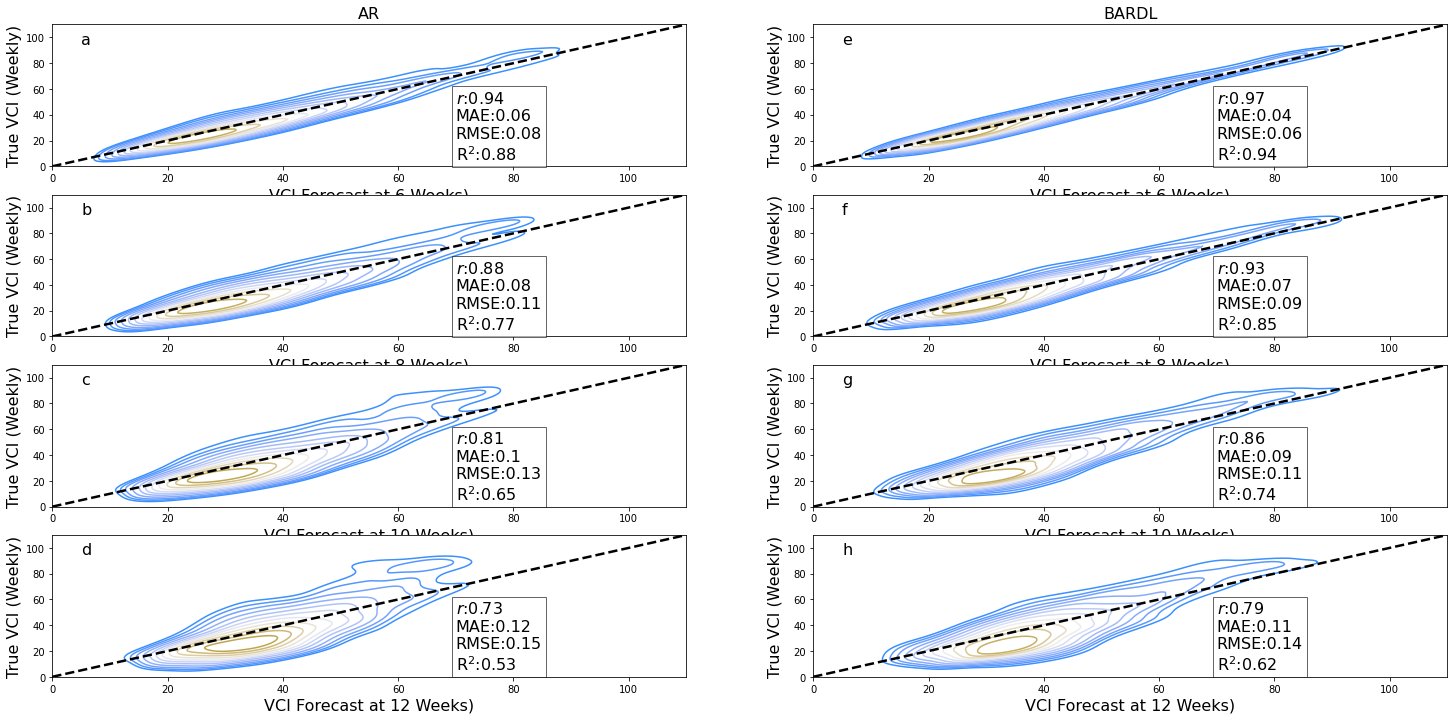

In [28]:
metrics_ls = []
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(25, 12))
for a, ax in enumerate(axs.reshape(-1)):
    i  = [106,206,108,208,110,210,112,212][a]
    g  = [6,6,8,8,10,10,12,12][a]
    t  = ['a','e','b','f','c','g','d','h'][a]
    m  = ['AR','BARDL','AR','BARDL','AR','BARDL','AR','BARDL','AR','BARDL'][a]
    hor = allData[allData['Horizon0']==i]
    corr = np.corrcoef(hor.VCI_Observed.values, hor.VCI_Forecast.values)
    mae2 = mean_absolute_error(hor.VCI_Observed.values, hor.VCI_Forecast.values)
    rmse2 = np.sqrt(mean_squared_error(hor.VCI_Observed.values, hor.VCI_Forecast.values))
    r2 = r2_score(hor.VCI_Observed.values, hor.VCI_Forecast.values)
    metrics_ls.append(pd.DataFrame({'Model':[m], 'Horizon':[g], 'R2':[r2], 'MAE':[mae2], 'RMSE':[rmse2]}))
    sns.kdeplot(hor["VCI_Forecast"]*100, hor["VCI_Observed"]*100, cmap=cc.cm.bwy,levels=12, thresh=0.2, ax=ax)
    ax.set_ylabel('True VCI (Weekly)', fontsize=16)
    ax.set_xlabel(f'VCI Forecast at {g} Weeks)', fontsize=16)
    if (a == 0) or (a==1):
        ax.set_title(m, fontsize=16)
    ax.set_xlim(0,110)
    ax.set_ylim(0,110)
    ax.plot((0,110), (0,110), 'k--', lw=2.5)
    ax.annotate(t, (5,95) , fontsize=16)
    txt = ax.text(x=70, y=5, s=f'$r$:{corr[0,1].round(2)}\nMAE:{mae2.round(2)}\nRMSE:{rmse2.round(2)}\nR$^2$:{r2.round(2)}', fontsize=16)
    txt.set_bbox(dict(facecolor='white', alpha=0.6))
# fig.suptitle('B')
# plt.savefig(f'AR_BARDL_Scatter_V3M.pdf', dpi=300)

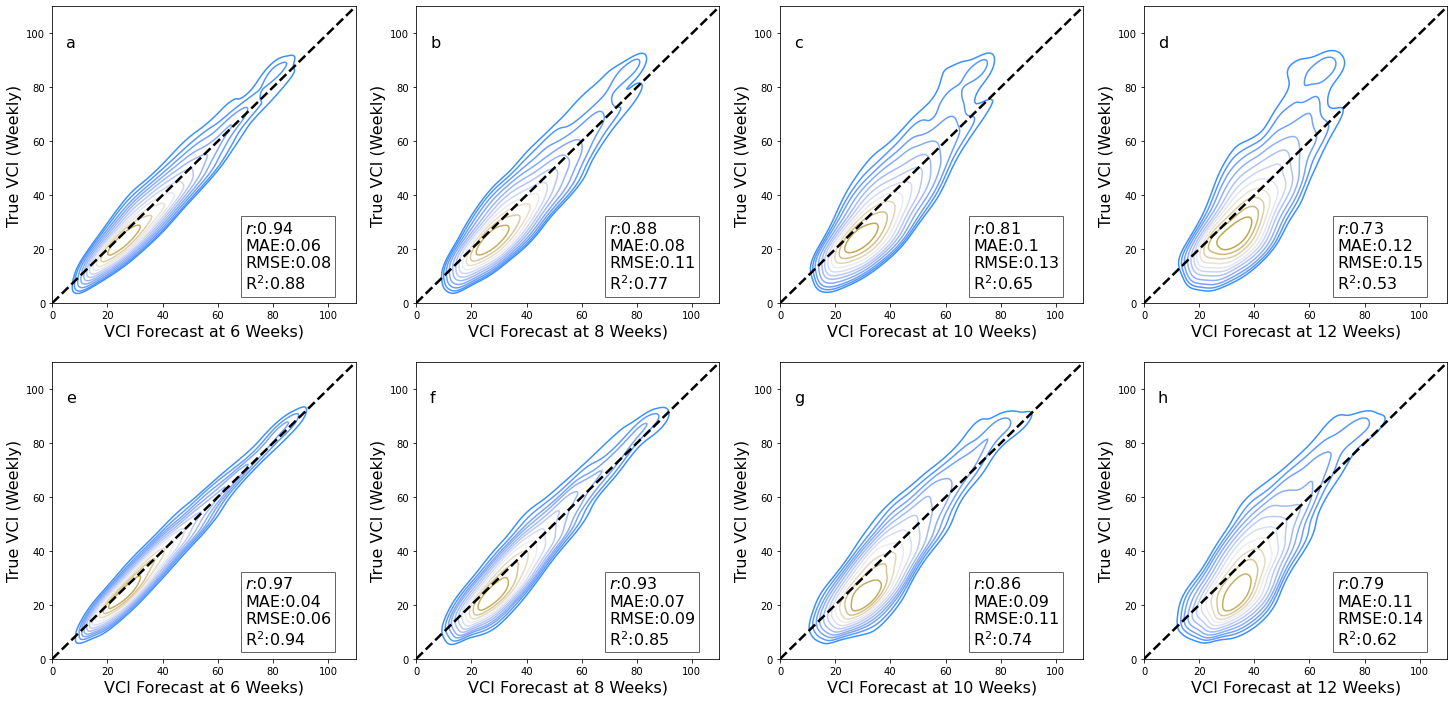

In [156]:
metrics_ls = []
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(25, 12))
for a, ax in enumerate(axs.reshape(-1)):
    i  = [106,108,110,112,206,208,210,212][a]
    g  = [6,8,10,12,6,8,10,12][a]
    t  = ['a','b','c','d','e','f','g','h'][a]
    m  = ['AR','AR','AR','AR','BARDL','BARDL','BARDL','BARDL'][a]
    hor = allData[allData['Horizon0']==i]
    corr = np.corrcoef(hor.VCI_Observed.values, hor.VCI_Forecast.values)
    mae2 = mean_absolute_error(hor.VCI_Observed.values, hor.VCI_Forecast.values)
    rmse2 = np.sqrt(mean_squared_error(hor.VCI_Observed.values, hor.VCI_Forecast.values))
    r2 = r2_score(hor.VCI_Observed.values, hor.VCI_Forecast.values)
    metrics_ls.append(pd.DataFrame({'Model':[m], 'Horizon':[g], 'R2':[r2], 'MAE':[mae2], 'RMSE':[rmse2]}))
    sns.kdeplot(hor["VCI_Forecast"]*100, hor["VCI_Observed"]*100, cmap=cc.cm.bwy,levels=12, thresh=0.2, ax=ax)
    ax.set_ylabel('True VCI (Weekly)', fontsize=16)
    ax.set_xlabel(f'VCI Forecast at {g} Weeks)', fontsize=16)
#     if (a == 0) or (a==1):
#         ax.set_title(m, fontsize=16)
    ax.set_xlim(0,110)
    ax.set_ylim(0,110)
    ax.plot((0,110), (0,110), 'k--', lw=2.5)
    ax.annotate(t, (5,95) , fontsize=16)
    txt = ax.text(x=70, y=5, s=f'$r$:{corr[0,1].round(2)}\nMAE:{mae2.round(2)}\nRMSE:{rmse2.round(2)}\nR$^2$:{r2.round(2)}', fontsize=16)
    txt.set_bbox(dict(facecolor='white', alpha=0.6))
# fig.suptitle('B')
plt.savefig(f'AR_BARDL_Scatter_V3M2.pdf', dpi=300)

In [30]:
met = pd.concat(metrics_ls)
met2 = pd.melt(met,id_vars=['Model', 'Horizon'], value_vars=['R2', 'MAE', 'RMSE'],var_name=['Metrics'] )
met2 = met2[met2.Horizon.isin([6,8,10,12])]

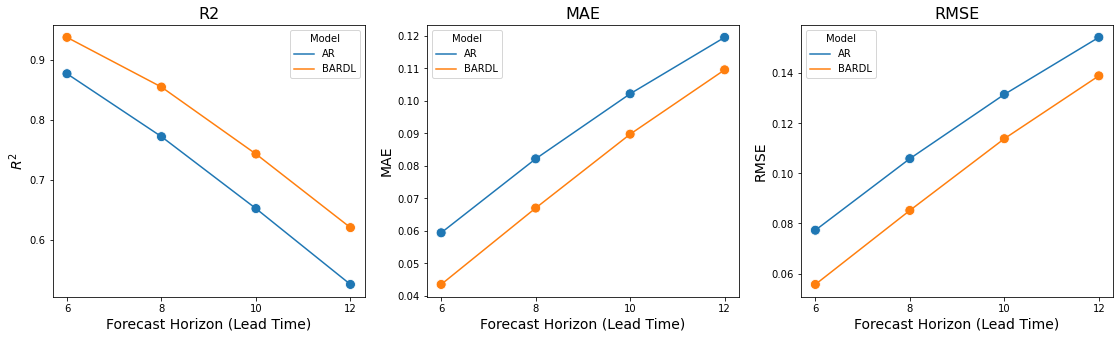

In [31]:
metric = ['R2','MAE','RMSE']
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19, 5))
for a, ax in enumerate(axs.reshape(-1)):
    m = ['R2','MAE','RMSE'][a]
    metric_df1 = met2[met2.Metrics == m]
    ax.set_title(m, fontsize=16)

    s = sns.scatterplot(data=metric_df1, x='Horizon', y='value', hue='Model', s=100, legend=False, ax=ax)
    s = sns.lineplot(data=metric_df1, x='Horizon', y='value', hue='Model', ax=ax)
    ax.set_xticks(np.arange(6, 13, 2))
    if m == 'R2':
        ax.set_ylabel('$R^2$', fontsize=14)
    else:
        ax.set_ylabel(m, fontsize=14)
    ax.set_xlabel('Forecast Horizon (Lead Time)', fontsize=14)
plt.savefig('compare_metrics_plot.pdf', dpi=300)
plt.savefig('compare_metrics_plot.png', dpi=300)

(1000, 10500)
(1000, 10500)
(1000, 10500)
(1000, 10500)
(1000, 10500)


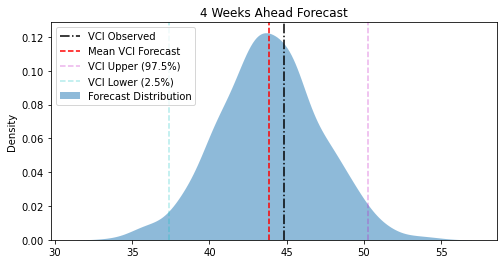

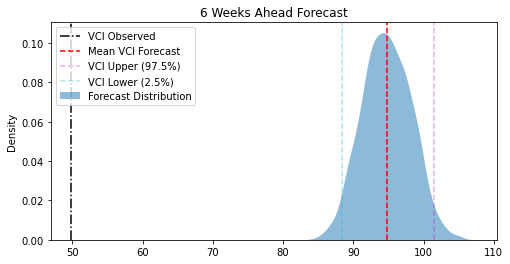

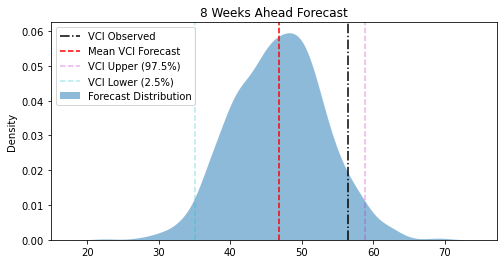

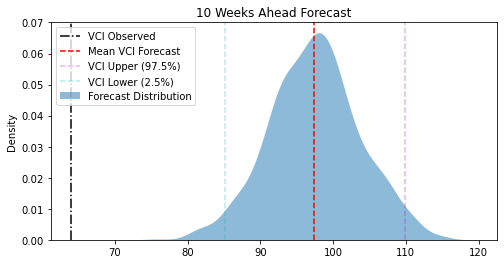

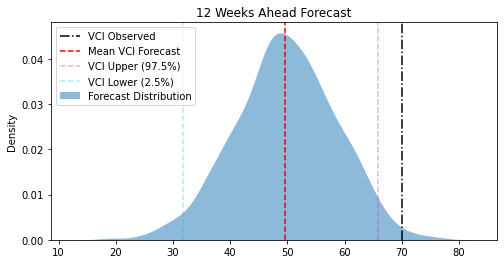

In [158]:
# plt.figure(figsize=(8,5))
for i, h in enumerate([4,6,8,10,12]):
    meanarr = bout_df2[bout_df2.Horizon==h]['Means'].values
    ddf = bout_df2[bout_df2.Horizon==h].reset_index()
    
    farr0 = np.load(arr_dat0[i])
    print(farr0.shape)
    farr1 = farr0 + meanarr
    subArr = farr1[:,2600]
    obs_val = ddf.loc[2600]
#     print(obs_val)
    plt.figure(figsize=(8,4))
    sns.kdeplot(subArr*100, fill=True, alpha=0.5, linewidth=0, label=f'Forecast Distribution')
    plt.axvline(obs_val.VCI_Observed*100, c='k', ls='-.', label='VCI Observed')
    plt.axvline(np.mean(subArr*100),  c='r', ls='--',label='Mean VCI Forecast')
    plt.axvline(np.percentile(subArr*100, 97.5),  c='m', ls='--',alpha=0.3, label='VCI Upper (97.5%)')
    plt.axvline(np.percentile(subArr*100, 2.5),  c='c', ls='--',alpha=0.3, label='VCI Lower (2.5%)')
    plt.title(f'{h} Weeks Ahead Forecast')
    plt.legend(loc='upper left')
    plt.savefig(f'Forecast_Dist_{h}_0.png', bbox_inches='tight')

In [38]:
catch = []
outBounds = {'VCI_Upper':[], 'VCI_Lower':[]}
for i, h in enumerate([4,6,8,10,12]):
    meanarr =bout_df2[bout_df2.Horizon==h]['Means'].values
    farr0 = np.load(arr_dat0[i])
    farr1 = farr0 + meanarr
    for s in np.arange(farr1.shape[1]):
        subArr = farr1[:,s]
        if (h==4) & (s == 2501):
            catch.append(subArr)
            
        outBounds['VCI_Upper'].append(np.percentile(subArr.ravel(), 95))
        outBounds['VCI_Lower'].append(np.percentile(subArr.ravel(), 5))
bounds = pd.DataFrame(outBounds)

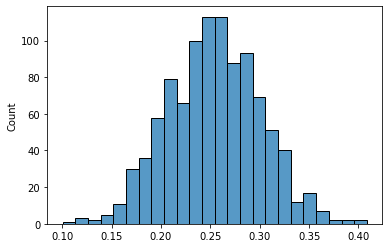

In [39]:
sns.histplot(catch[0])

### Compute the PICP, MPIW and put them in tables 

In [99]:
outMet = {'County':[],'Horizon':[], 'PICP':[], 'MPIW':[]}
for c in bout_df3.County.unique():
    sub = bout_df3[bout_df3.County==c]
    for h in [4,6,8,10,12]:
        sub0 = sub[sub.Horizon==h][-100:]
        PICP, MPIW = getPICI_AR(sub0['VCI_Observed'].values, sub0['VCI_Upper'].values, sub0['VCI_Lower'].values)
        outMet['County'].append(c)
        outMet['Horizon'].append(h)
        outMet['PICP'].append(PICP)
        outMet['MPIW'].append(MPIW)
outMetDF = pd.DataFrame(outMet)

outMetDFArid = outMetDF.loc[outMetDF.County.isin(county1_arid)]
outMetDFSArid = outMetDF.loc[outMetDF.County.isin(county1_sarid)]

met_dfVCIO = pd.read_csv('ARDL_CV/Metrics_VCI_ForecastDF_VCI_AR.csv')
met_dfVCIO = met_dfVCIO.loc[:,['County','Horizon','PICP','MPIW']]
MetARArid = met_dfVCIO.loc[met_dfVCIO.County.isin(county1_arid)]
MetARSArid = met_dfVCIO.loc[met_dfVCIO.County.isin(county1_sarid)]

arid_ARCI = MetARArid.pivot_table(columns=['Horizon'], values=['PICP','MPIW'], index=['County'])
arid_ARCI.loc['Mean'] = arid_ARCI.mean()
sarid_ARCI = MetARSArid.pivot_table(columns=['Horizon'], values=['PICP','MPIW'], index=['County'])
sarid_ARCI.loc['Mean'] = sarid_ARCI.mean()

arid_ARCI.columns = [f'{a}_{b}' for a, b in arid_ARCI.columns]
CI = [c for c in arid_ARCI.columns if 'PICP' in c ]
MPIW = [c for c in arid_ARCI.columns if 'MPIW' in c ]

### Create tables 

In [101]:
arci_dict = pd.DataFrame()
for i, w in zip(CI, MPIW):
    c  = arid_ARCI.index
    n = arid_ARCI[i].values
    m = arid_ARCI[w].values
    arci_dict['County'] = c
    arci_dict[i]=[f'{v.round(2)}({u.round(2)})' for v, u in zip(n, m)]

In [102]:
arci_dict

,County,PICP_4,PICP_6,PICP_8,PICP_10,PICP_12
0,Garissa,0.94(0.21),0.93(0.35),0.93(0.49),0.95(0.6),0.94(0.69)
1,Isiolo,0.92(0.17),0.94(0.29),0.93(0.4),0.93(0.5),0.93(0.58)
2,Mandera,0.95(0.2),0.94(0.34),0.94(0.45),0.94(0.55),0.94(0.63)
3,Marsabit,0.93(0.14),0.92(0.25),0.91(0.36),0.92(0.46),0.93(0.55)
4,Samburu,0.94(0.15),0.95(0.26),0.95(0.37),0.95(0.46),0.96(0.55)
5,Tana-River,0.94(0.21),0.94(0.34),0.93(0.45),0.95(0.54),0.95(0.61)
6,Turkana,0.94(0.14),0.95(0.24),0.96(0.34),0.95(0.44),0.96(0.52)
7,Wajir,0.93(0.23),0.93(0.37),0.94(0.49),0.95(0.58),0.95(0.66)
8,Mean,0.94(0.18),0.94(0.31),0.94(0.42),0.94(0.52),0.94(0.6)


In [103]:
sarid_ARCI.columns = [f'{a}_{b}' for a, b in sarid_ARCI.columns]
CI = [c for c in sarid_ARCI.columns if 'PICP' in c ]
MPIW = [c for c in sarid_ARCI.columns if 'MPIW' in c ]

In [104]:
sarci_dict = pd.DataFrame()
for i, w in zip(CI, MPIW):
    c  = sarid_ARCI.index
    n = sarid_ARCI[i].values
    m = sarid_ARCI[w].values
    sarci_dict['County'] = c
    sarci_dict[i]=[f'{v.round(2)}({u.round(2)})' for v, u in zip(n, m)]

In [105]:
arid_CI = outMetDFArid.pivot_table(columns=['Horizon'], values=['PICP','MPIW'], index=['County'])
arid_CI.loc['Mean'] = arid_CI.mean()
sarid_CI = outMetDFSArid.pivot_table(columns=['Horizon'], values=['PICP','MPIW'], index=['County'])
sarid_CI.loc['Mean'] = sarid_CI.mean()

In [106]:
arid_CI.columns = [f'{a}_{b}' for a, b in arid_CI.columns]

In [107]:
arid_CI

,MPIW_4,MPIW_6,MPIW_8,MPIW_10,MPIW_12,PICP_4,PICP_6,PICP_8,PICP_10,PICP_12
County,,,,,,,,,,
Garissa,0.081567,0.061125,0.066297,0.085477,0.061297,0.14,0.13000,0.06000,0.03,0.0800
Isiolo,0.069583,0.112367,0.069404,0.064228,0.109159,0.11,0.57000,0.25000,0.12,0.3900
Mandera,0.213348,0.181316,0.237888,0.281392,0.179670,0.49,0.59000,0.61000,0.85,0.3800
Marsabit,0.238538,0.241851,0.243895,0.167952,0.187699,0.63,0.69000,0.97000,0.57,0.4800
Samburu,0.277305,0.331168,0.333057,0.322444,0.230594,0.70,0.61000,0.88000,0.84,0.8100
Tana-River,0.223121,0.307962,0.369648,0.337709,0.233315,0.51,0.50000,0.90000,0.53,0.2200
Turkana,0.469262,0.385959,0.424106,0.402445,0.367417,0.78,0.88000,0.69000,0.84,0.6900
Wajir,0.304798,0.306040,0.332884,0.283859,0.358096,0.72,0.64000,0.45000,0.78,0.8900
Mean,0.234690,0.240973,0.259647,0.243188,0.215906,0.51,0.57625,0.60125,0.57,0.4925


In [108]:
CI = [c for c in arid_CI.columns if 'CI' in c ]
MPIW = [c for c in arid_CI.columns if 'MPIW' in c ]

In [109]:
ci_dict = pd.DataFrame()
for i, w in zip(CI, MPIW):
    c  = arid_CI.index
    n = arid_CI[i].values
    m = arid_CI[w].values
    ci_dict['County'] = c
    ci_dict[i]=[f'{v.round(2)}({u.round(2)})' for v, u in zip(n, m)]

In [110]:
ci_dict

""


In [246]:
sarid_CI

CI                                            MPIW  \
Horizon              4         6         8       10        12        4    
County                                                                    
Baringo        0.886000  0.886000  0.892000  0.8880  0.898000  0.082299   
Kajiado        0.890000  0.884000  0.884000  0.8860  0.896000  0.067512   
Kilifi         0.912000  0.906000  0.914000  0.8940  0.904000  0.124686   
Kitui          0.858000  0.826000  0.810000  0.8140  0.818000  0.092443   
Laikipia       0.914000  0.912000  0.900000  0.8860  0.870000  0.064707   
Makueni        0.882000  0.862000  0.826000  0.8080  0.836000  0.092945   
Meru           0.886000  0.864000  0.850000  0.8440  0.834000  0.081028   
Narok          0.888000  0.878000  0.894000  0.8980  0.878000  0.076024   
Nyeri          0.928000  0.912000  0.924000  0.9000  0.874000  0.103925   
Taita-Taveta   0.816000  0.794000  0.764000  0.7820  0.802000  0.078253   
Tharaka-Nithi  0.898000  0.874000  0.844000  0.8260  0.828000  0.097056   
West-Pokot     0.894000  0.892000  0.886000  0.8760  0.872000  0.072234   
Mean           0.887667  0.874167  0.865667  0.8585  0.859167  0.086093   

                                                       
Horizon              6         8         10        12  
County                                                 
Baringo        0.179822  0.294730  0.401268  0.493256  
Kajiado        0.140665  0.224312  0.305967  0.376735  
Kilifi         0.217710  0.294092  0.359022  0.409009  
Kitui          0.172062  0.248118  0.317526  0.379197  
Laikipia       0.139441  0.232994  0.331180  0.423856  
Makueni        0.179939  0.266344  0.340945  0.403519  
Meru           0.159851  0.240235  0.312909  0.374142  
Narok          0.158084  0.246865  0.329639  0.401230  
Nyeri          0.191522  0.278445  0.362726  0.436694  
Taita-Taveta   0.156734  0.235267  0.300226  0.352489  
Tharaka-Nithi  0.177495  0.251517  0.315121  0.363997  
West-Pokot     0.159325  0.263046  0.358845  0.439387  
Mean           0.169388  0.256330  0.336281  0.404459

In [247]:
sarid_CI.columns = [f'{a}_{b}' for a, b in sarid_CI.columns]

In [248]:
sci_dict = pd.DataFrame()
for i, w in zip(CI, MPIW):
    c  = sarid_CI.index
    n = sarid_CI[i].values
    m = sarid_CI[w].values
    sci_dict['County'] = c
    sci_dict[i]=[f'{v.round(2)}({u.round(2)})' for v, u in zip(n, m)]
sci_dict

,County,CI_4,CI_6,CI_8,CI_10,CI_12
0,Baringo,0.89(0.08),0.89(0.18),0.89(0.29),0.89(0.4),0.9(0.49)
1,Kajiado,0.89(0.07),0.88(0.14),0.88(0.22),0.89(0.31),0.9(0.38)
2,Kilifi,0.91(0.12),0.91(0.22),0.91(0.29),0.89(0.36),0.9(0.41)
3,Kitui,0.86(0.09),0.83(0.17),0.81(0.25),0.81(0.32),0.82(0.38)
4,Laikipia,0.91(0.06),0.91(0.14),0.9(0.23),0.89(0.33),0.87(0.42)
5,Makueni,0.88(0.09),0.86(0.18),0.83(0.27),0.81(0.34),0.84(0.4)
6,Meru,0.89(0.08),0.86(0.16),0.85(0.24),0.84(0.31),0.83(0.37)
7,Narok,0.89(0.08),0.88(0.16),0.89(0.25),0.9(0.33),0.88(0.4)
8,Nyeri,0.93(0.1),0.91(0.19),0.92(0.28),0.9(0.36),0.87(0.44)
9,Taita-Taveta,0.82(0.08),0.79(0.16),0.76(0.24),0.78(0.3),0.8(0.35)


In [249]:
arci  = pd.concat([arci_dict, ci_dict], axis=1)
sarci = pd.concat([sarci_dict, sci_dict], axis=1)
sarci

,County,PICP_4,PICP_6,PICP_8,PICP_10,PICP_12,County,CI_4,CI_6,CI_8,CI_10,CI_12
0,Baringo,0.95(0.17),0.95(0.29),0.95(0.41),0.94(0.53),0.94(0.64),Baringo,0.89(0.08),0.89(0.18),0.89(0.29),0.89(0.4),0.9(0.49)
1,Kajiado,0.93(0.17),0.93(0.3),0.93(0.41),0.94(0.52),0.94(0.61),Kajiado,0.89(0.07),0.88(0.14),0.88(0.22),0.89(0.31),0.9(0.38)
2,Kilifi,0.94(0.2),0.94(0.31),0.95(0.39),0.96(0.45),0.96(0.51),Kilifi,0.91(0.12),0.91(0.22),0.91(0.29),0.89(0.36),0.9(0.41)
3,Kitui,0.94(0.2),0.94(0.34),0.94(0.45),0.94(0.55),0.95(0.62),Kitui,0.86(0.09),0.83(0.17),0.81(0.25),0.81(0.32),0.82(0.38)
4,Laikipia,0.95(0.13),0.95(0.24),0.95(0.35),0.96(0.46),0.96(0.56),Laikipia,0.91(0.06),0.91(0.14),0.9(0.23),0.89(0.33),0.87(0.42)
5,Makueni,0.93(0.2),0.93(0.34),0.93(0.46),0.94(0.56),0.94(0.64),Makueni,0.88(0.09),0.86(0.18),0.83(0.27),0.81(0.34),0.84(0.4)
6,Meru,0.95(0.17),0.95(0.3),0.96(0.43),0.95(0.53),0.96(0.6),Meru,0.89(0.08),0.86(0.16),0.85(0.24),0.84(0.31),0.83(0.37)
7,Narok,0.95(0.17),0.95(0.28),0.94(0.37),0.94(0.45),0.95(0.52),Narok,0.89(0.08),0.88(0.16),0.89(0.25),0.9(0.33),0.88(0.4)
8,Nyeri,0.95(0.18),0.94(0.3),0.93(0.41),0.94(0.51),0.96(0.6),Nyeri,0.93(0.1),0.91(0.19),0.92(0.28),0.9(0.36),0.87(0.44)
9,Taita-Taveta,0.93(0.19),0.93(0.32),0.93(0.44),0.92(0.54),0.93(0.62),Taita-Taveta,0.82(0.08),0.79(0.16),0.76(0.24),0.78(0.3),0.8(0.35)


In [54]:
# Function for computing forecast probabilities
def NewcatProbs(farr0):
    cats = {'FNo-Drought':[],'FDrought':[]}
    for i in np.arange(farr0.shape[1]):
        cats['FNo-Drought'].append(len(farr0[:,i][(farr0[:,i] > 0.35)])/1000)
        cats['FDrought'].append(len(farr0[:,i][(farr0[:,i] < 0.35)])/1000)
    return pd.DataFrame(cats)

In [63]:
new_bout_df = pd.concat([bout_df0, probs_out], axis=1)
new_bout_df = new_bout_df[new_bout_df.County.isin(county1)]

In [478]:
#Convert the observed data to binaries (Drought , No-Drought)
new_bout_df['Obs_No-Drought'] = np.where((new_bout_df['VCI_Observed'] > 0.35), 1, 0)
new_bout_df['Obs_Drought'] = np.where((new_bout_df['VCI_Observed'] < 0.35), 1, 0)

In [70]:
arid_0 = new_bout_df[new_bout_df.County.isin(county1_arid)]
sarid_0 = new_bout_df[new_bout_df.County.isin(county1_sarid)]

In [71]:
#Put forecast probabilities and observed binaries into bins
def getFreqs1(df,forecast_probs,observed_binary, bin_steps=0.2):
    freqs = {'Horizon':[],'FcastProbs':[],'Fcastfreqs':[], 'Obsfreq':[]}
    fps = np.arange(0, 1.1, bin_steps)
    for f in [4,6,8,10,12]:
        subA = df[df['Horizon']==f]
        subB = subA.loc[:,[forecast_probs,observed_binary]]
        for i in fps:
            fcounts1 = [subB[(subB[forecast_probs]>=i)&(subB[forecast_probs]<=i+bin_steps)]]
            freqs['Fcastfreqs'].append(len(fcounts1[0]))
            freqs['Obsfreq'].append(len(fcounts1[0][fcounts1[0][observed_binary]==1]))
            freqs['FcastProbs'].append(i)
            freqs['Horizon'].append(f)
                
    freqs_out = pd.DataFrame(freqs)
    freqs_out['Obs_Freq'] = freqs_out['Obsfreq']/freqs_out['Fcastfreqs']
    return freqs_out

## Plot Reliability Diagrams and Sharpness 

['FNo-Drought', 'Obs_No-Drought']
['FDrought', 'Obs_Drought']


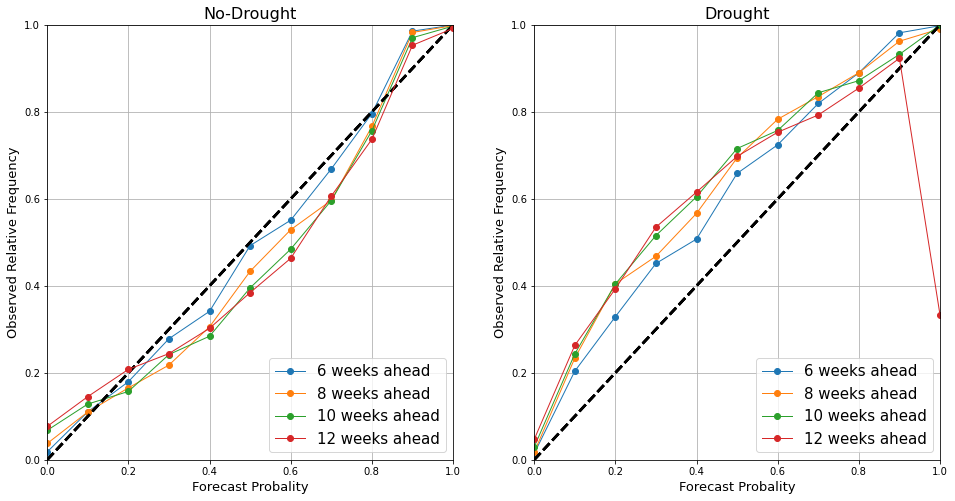

In [497]:
freq_ls = []
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
for a, ax in enumerate(axs.reshape(-1)):
    cols = (['FNo-Drought', 'Obs_No-Drought'],['FDrought','Obs_Drought'])[a]
    freqs_out = getFreqs1(new_bout_df,cols[0], cols[1], 0.1)
    bss = []
    print(cols)
    for h in [6,8,10,12]:
        sub_step = freqs_out[freqs_out['Horizon']==h]
        sub_data = new_bout_df[new_bout_df['Horizon']==h]
        sub_step['Threshold'] = f'{cols[1][4:]}'
        freq_ls.append(sub_step)
        brier_score = brier_score_loss(sub_data[cols[1]], sub_data[cols[0]], pos_label=1)
        bss.append(brier_score)
        ax.plot((0,1), (0,1), 'k--', lw=2.5 , color='black')
        ax.set_title(f'{cols[1][4:]}', fontsize=16)
        ax.plot(sub_step.FcastProbs, sub_step.Obs_Freq, marker='o', lw=1, label=f'{h} weeks ahead')
        ax.set_ylabel("Observed Relative Frequency", fontsize=13)
        ax.set_xlabel("Forecast Probality", fontsize=13)
        ax.set_ylim([0, 1.0])
        ax.set_xlim([0, 1.0])
        ax.grid(True)
        ax.legend(loc='lower right', fontsize=15)
#     txt = ax.text(x=0.02, y=0.83, s=f'Brier Score 6 Week: {bss[0].round(3)}\nBrier Score 8 Week: {bss[1].round(3)}\nBrier Score 10 Week: {bss[2].round(3)}\nBrier Score 12 Week: {bss[3].round(3)}', fontsize=14)
#     txt.set_bbox(dict(facecolor='white', alpha=0.6))
    plt.savefig(f'Reliability_Plot_weeks.pdf', bbox_inches='tight')

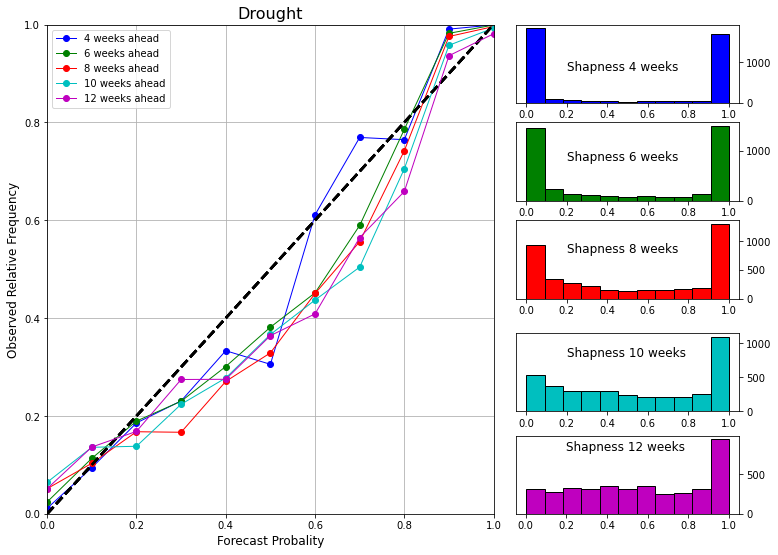

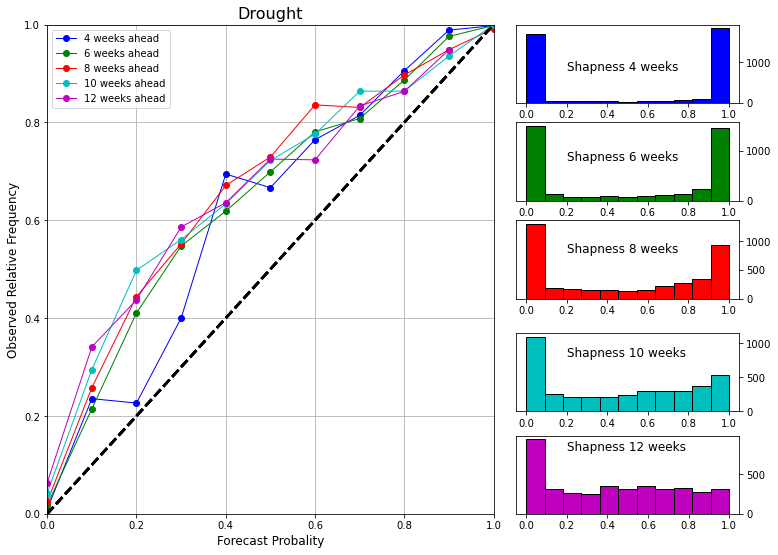

In [138]:
color = ['b', 'g', 'r', 'c', 'm', 'y']
for f in (['FNo-Drought', 'Obs_No-Drought'],['FDrought','Obs_Drought']):
# for f,o in zip(['FWet', 'FNormal','FModerate', 'FSevere','FExtreme'], ['Obs_Wet', 'Obs_Normal','Obs_Moderate', 'Obs_Severe', 'Obs_Extreme']):
    fig, (ax) = plt.subplots(1, 1, figsize=(8, 9))
    clim = [] 
    freqs_out = getFreqs1(arid_0,f[0],f[1], 0.1)
    for h, i, g in zip([4,6,8,10,12], [.6,.4,.2,-.03,-.24], color):
        ss1 = arid_0[arid_0.Horizon==h]
        sub_step = freqs_out[freqs_out['Horizon']==h]
        sub_step['Threshold'] = f'{o[4:]}'
        freq_ls.append(sub_step)
        ax.plot((0,1), (0,1), 'k--', lw=2.5 , color='black')
        ax.set_title(f'{o[4:]}', fontsize=16)
        ax.plot(sub_step.FcastProbs, sub_step.Obs_Freq, marker='o', color=g, lw=1, label=f'{h} weeks ahead')
        ax.set_ylabel("Observed Relative Frequency", fontsize=12)
        ax.set_xlabel("Forecast Probality", fontsize=12)
        ax.set_ylim([0, 1.0])
        ax.set_xlim([0, 1.0])
        ax.grid(True)
#         clim.append(sum(sub_step.Obsfreq)/sum(sub_step.Fcastfreqs))
#         c = clim[0]
#         plt.axhline(c,  ls=':', lw=2.5, c='k')
#     # Plot skill area
#         x0 = [c, 1]
#         y01 = [c, 0.5*(1+c)]
#         y02 = [1, 1]
#         _= plt.fill_between(x0, y01, y02, where=y01 <= y02, facecolor='lightgreen')
#         x1 = [0, c]
#         y11 = [0.5*c, c]
#         y12 = [0, 0]
#         _= plt.fill_between(x1, y11, y12, where=y11 >= y12, facecolor='lightgreen')
        ax.legend(loc="upper left")

        # Create an inset outside the axes
        axins = inset_axes(ax, width="100%", height="40%",
                           bbox_to_anchor=(1.05, i, .5, .4),
                           bbox_transform=ax.transAxes, loc=2, borderpad=0)
        axins.tick_params(left=False, right=True, labelleft=False, labelright=True)
        axins.hist(ss1[f[0]].values, color=g, bins=11, ec="k")
        axins.annotate(f'Shapness {h} weeks', (0.2,800) , fontsize=12)
    plt.savefig(f'ARID_RD_{o[4:]}_weeks.png', bbox_inches='tight')

# Make ROC plots 

[95.7805229]
[95.7805229  91.89311848]
[95.7805229  91.89311848 87.67902357]
[95.7805229  91.89311848 87.67902357 82.98177816]


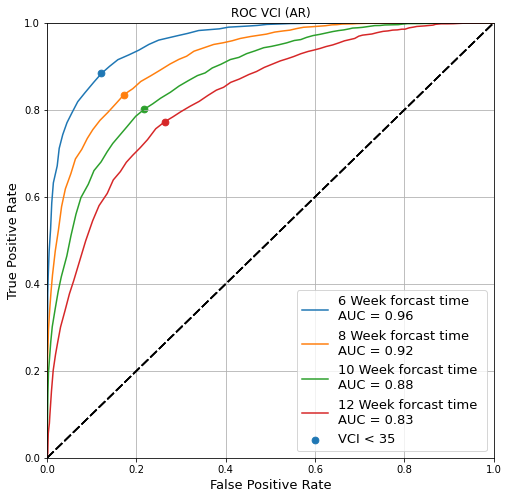

In [29]:
plotROC(bout_dfVCIO, 'VCI (AR)', 'VCI') #ROC plots for AR Methods

[97.82395579]
[97.82395579 94.70724685]
[97.82395579 94.70724685 89.66565959]
[97.82395579 94.70724685 89.66565959 83.92516445]


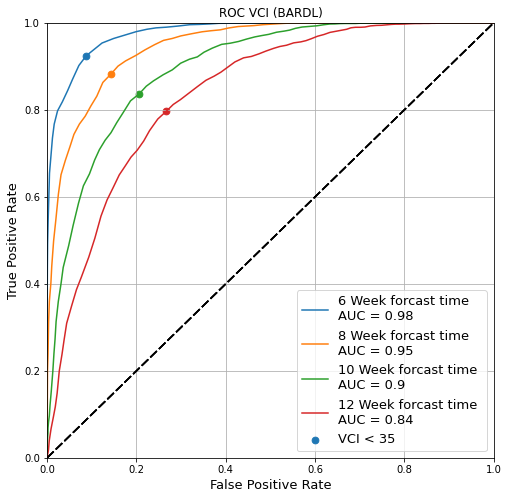

In [30]:
plotROC(bout_df1, 'VCI (BARDL)', 'VCI') #ROC plots for BARDL Methods

In [49]:
# Combine ROC outputs 
def joinROC(files):
    df_ls = []
    for f in files:
        hor = f.split('_')[-1][:-4]
        df = pd.read_csv(f)
        df['Horizon'] = np.repeat(hor, len(df))
        df_ls.append(df)
    return pd.concat(df_ls)

roc_filesaAR = glob.glob('*(AR)*csv')
roc_filesaBAR = glob.glob('*(BARDL)*csv')

roc_ar = joinROC(roc_filesaAR)
roc_bar = joinROC(roc_filesaBAR)

sub = roc_ar[roc_ar.Horizon==str(8)]
sub.loc[35].TPR

colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728']

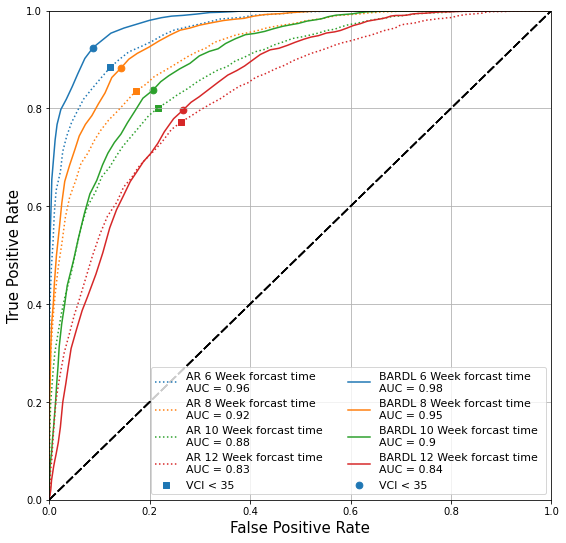

In [104]:
# Plot Joint ROC Curves
plt.figure(figsize=(9,9))
for i, h in enumerate([6,8,10,12]):
    sub_ar = roc_ar[roc_ar.Horizon==str(h)]
    sub_bar = roc_bar[roc_bar.Horizon==str(h)]
    AUC0 = np.trapz(sub_ar.TPR,sub_ar.FPR,dx=0.001)
    AUC1 = np.trapz(sub_bar.TPR,sub_bar.FPR,dx=0.001) 
    plt.plot(sub_ar.FPR,sub_ar.TPR,ls=':', color=colors[i], label=f'AR {h} Week forcast time \nAUC = {round(AUC0,2)}')
    plt.plot(sub_bar.FPR,sub_bar.TPR,color=colors[i],label=f'BARDL {h} Week forcast time \nAUC = {round(AUC1,2)}')
    plt.scatter(sub_ar.loc[35].FPR, sub_ar.loc[35].TPR,s=45, marker='s', color=colors[i], label = ('VCI < 35')) 
    plt.scatter(sub_bar.loc[35].FPR, sub_bar.loc[35].TPR,s=45, color=colors[i], label = ('VCI < 35'))
    yx = np.linspace(0,1,10)
    plt.plot(yx,yx, dashes=[6, 2],color='black')

    plt.xlim(0,1)
    plt.ylim(0,1)
#     plt.legend(fontsize=13)
    plt.grid(True)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.xlabel('False Positive Rate', fontsize=15)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,4,6,8,1,3,5,7,9]
plt.legend([handles[o] for o in order],[labels[o] for o in order], ncol=2, loc='center center', fontsize=11)
plt.savefig('Joint_ROC_Plots.pdf', dpi=300, bbox_inches='tight')

In [147]:
# Select the data for sample PICP and MPIW Time Series 
sub1 = bout_df3[bout_df3.County=='Mandera']
select = []
for h in [4,6,8,10,12]:
    select.append(sub1[sub1.Horizon==h][-53:].reset_index())
select_df = pd.concat(select)

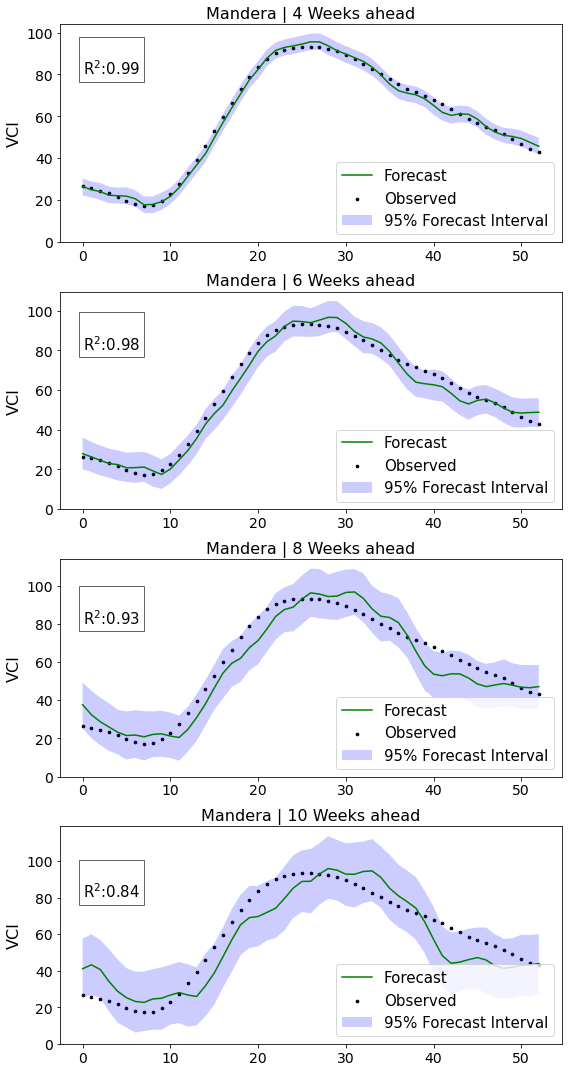

In [152]:
date = pd.date_range(start='2018-01-07', end='2019-01-06', freq='W')
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(8, 15))
for p, ax in enumerate(axs.reshape(-1)):
    hor = [4,6,8,10,12][p]
    pred_sub = select_df[select_df['Horizon']==hor]
    pred_sub['Date'] = date
    x_axis = pred_sub.index
    cp = outMetDF[(outMetDF['County']=='Mandera') & (outMetDF['Horizon']==hor)]['PICP'].values[0]
    iw = outMetDF[(outMetDF['County']=='Mandera') & (outMetDF['Horizon']==hor)]['MPIW'].values[0]
    mae2 = mean_absolute_error(pred_sub.VCI_Observed.values, pred_sub.VCI_Forecast.values)
    r2 = r2_score(pred_sub.VCI_Observed.values, pred_sub.VCI_Forecast.values)
    
    ax.set_title(f'Mandera | {hor} Weeks ahead',fontsize=16)
    ax.scatter(x_axis, pred_sub.VCI_Observed*100, s=7, color='k', label='Observed')
    ax.plot(x_axis, pred_sub.VCI_Forecast*100, color='g', label='Forecast')
    ax.fill_between(x_axis, pred_sub.VCI_Upper1*100, pred_sub.VCI_Lower0*100, facecolor='blue', alpha=0.2, label='95% Forecast Interval')
    ax.set_ylabel('VCI',fontsize=16)
    ax.set_yticks(np.arange(0, 120, 20))
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
#     txt = ax.text(x=pred_sub.Date.values[0], y=70,
#                       s=f'PICP:{cp.round(2)},\nMPIW:{iw.round(2)},\nR$^2$:{r2.round(2)}',fontsize=15)
#     txt.set_bbox(dict(facecolor='white', alpha=0.6))
    txt = ax.text(x=x_axis.values[0], y=80,
                      s=f'\nR$^2$:{r2.round(2)}',fontsize=15)
    txt.set_bbox(dict(facecolor='white', alpha=0.6))
# #         ax.set_xlim(50,110)
    ax.legend(loc='lower right', fontsize=15)
    plt.tight_layout()
# plt.savefig(f'PICP_MPIW_VCI3M_LPS.pdf', dpi=300)
plt.savefig(f'TS.png', dpi=300)

In [150]:
sub2 = bout_dfVCIO[bout_dfVCIO.County=='Mandera']
select0 = []
for h in [4,6,8,10,12]:
    select0.append(sub2[sub2.Horizon==h][-53:].reset_index())
select_df0 = pd.concat(select0)

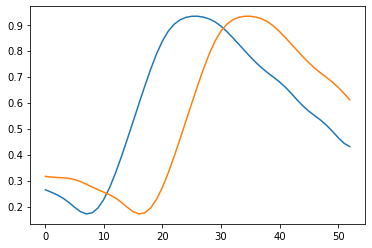

In [154]:
select_df[select_df['Horizon']==4].VCI_Observed.plot()
select_df0[select_df0['Horizon']==4].VCI_Observed.plot()

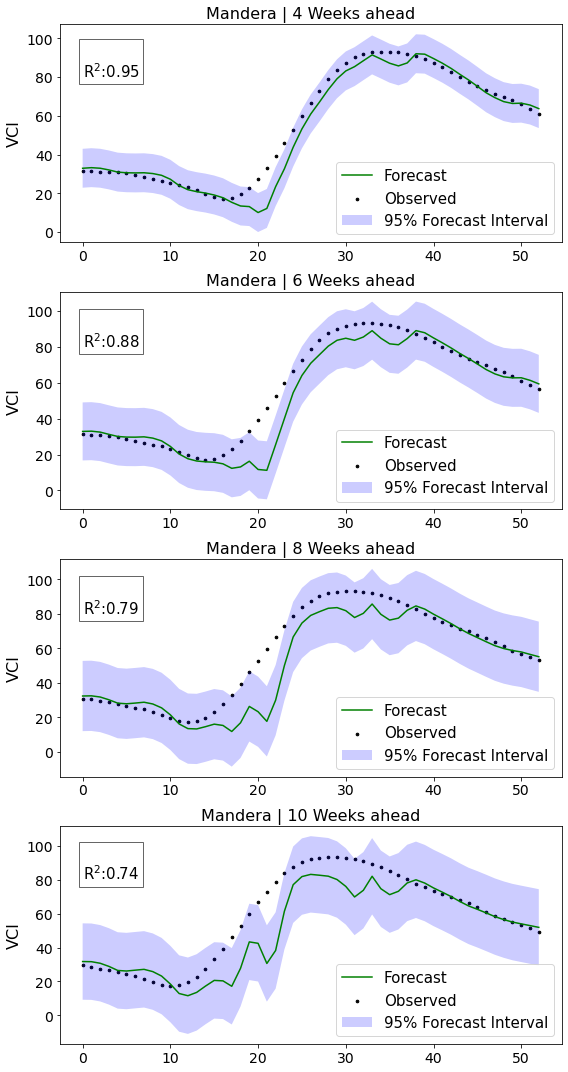

In [153]:
date = pd.date_range(start='2018-01-07', end='2019-01-06', freq='W')
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(8, 15))
for p, ax in enumerate(axs.reshape(-1)):
    hor = [4,6,8,10,12][p]
    pred_sub0 = select_df0[select_df0['Horizon']==hor]
    pred_sub0['Date'] = date
    x_axis = pred_sub.index
    cp = met_dfVCIO[(met_dfVCIO['County']=='Mandera') & (met_dfVCIO['Horizon']==hor)]['PICP'].values[0]
    iw = met_dfVCIO[(met_dfVCIO['County']=='Mandera') & (met_dfVCIO['Horizon']==hor)]['MPIW'].values[0]
    mae2 = mean_absolute_error(pred_sub0.VCI_Observed.values, pred_sub0.VCI_Forecast.values)
    r2 = r2_score(pred_sub0.VCI_Observed.values, pred_sub0.VCI_Forecast.values)
    
    ax.set_title(f'Mandera | {hor} Weeks ahead',fontsize=16)
    ax.scatter(x_axis, pred_sub0.VCI_Observed*100, s=7, color='k', label='Observed')
    ax.plot(x_axis, pred_sub0.VCI_Forecast*100, color='g', label='Forecast')
    ax.fill_between(x_axis, pred_sub0.VCI_Upper1*100, pred_sub0.VCI_Lower0*100, facecolor='blue', alpha=0.2, label='95% Forecast Interval')
    ax.set_ylabel('VCI',fontsize=16)
    ax.set_yticks(np.arange(0, 120, 20))
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
#     txt = ax.text(x=pred_sub.Date.values[0], y=70,
#                       s=f'PICP:{cp.round(2)},\nMPIW:{iw.round(2)},\nR$^2$:{r2.round(2)}',fontsize=15)
#     txt.set_bbox(dict(facecolor='white', alpha=0.6))
    txt = ax.text(x=x_axis.values[0], y=80,
                      s=f'\nR$^2$:{r2.round(2)}',fontsize=15)
    txt.set_bbox(dict(facecolor='white', alpha=0.6))
# #         ax.set_xlim(50,110)
    ax.legend(loc='lower right', fontsize=15)
    plt.tight_layout()
# plt.savefig(f'PICP_MPIW_VCI3M_LPS.pdf', dpi=300)
plt.savefig(f'ARTS.png', dpi=300)

## Compute and plot Relative Importance

In [219]:
from relativeImp import relativeImp
from matplotlib.colors import LinearSegmentedColormap

In [1]:
df_ls = []
aridscorr_ls = []
saridscorr_ls = []
target = ('VCI', 'Anom')
for v in county0:
    print(v)
    anom_vars_ = ['LST_Anom','Rainfall_Anom', 'SoilMoist_Anom',f'{target[0]}','Season']
    abs_vars = ['LST','Rainfall', 'SoilMoist',f'{target[0]}', 'Season']
    data_df = pd.read_csv(f'NDVI_MinMax3M/Weekly_{v}_SIM_Smooth_Anom_3M.csv')
    data_df['Date']=pd.to_datetime(data_df.Date)
    data_df0 = addSeason(data_df)
    data_df0 = data_df0[data_df0.Season == 'mam']
#     print(data_df0)
    if (target[0] == "VCI" and target[1] == "Anom"):
        scale_df1, mean = scaleValuesV(data_df0.loc[:,anom_vars_])
    elif (target[0] == "VCI"  and target[1] == "Abs"):
        scale_df1, mean = scaleValuesV(data_df0.loc[:,abs_vars])
#     elif target == "NDVI":
#         scale_df1, mean = scaleValuesS(data_df0.loc[:,vars_])


    for h in [4,6,8,10,12]:
        X_train, y_train = fcast_train_testDF_AR(scale_df1, p_order0=0,
                                                            p_order1=6, p_order2=6, 
                                                            q_order=6, s_lags=1,target_var=target[0], 
                                                            f_horizon=h)
       
        X_train1 = X_train.loc[:,[ c for c in X_train.columns if 'Season' not in c]]
        corr = X_train1.corr()
        corr0 = corr.loc[:,[ c for c in corr.columns if 'Rainfall' in c]]
        saridscorr_ls.append(corr0.iloc[-1,:])
        
        dep = X_train1.columns.tolist()[-1]
        indep = X_train1.columns.tolist()[:-1]

        df_results = relativeImp(X_train1, outcomeName =dep , driverNames = indep)
        df_results['Horizon'] = np.repeat(f'Horizon_{h}', len(df_results))
        df_results['County'] = np.repeat(v, len(df_results))
        df_ls.append(df_results)
df_results1 = pd.concat(df_ls)

hor = ['driver', 'Horizon_4','Horizon_6','Horizon_8','Horizon_10', 'Horizon_12']
trans = pd.pivot_table(df_results1, values=['normRelaImpt'], columns=['driver'], index=['Horizon'])
trans = trans.T.reset_index()
trans = trans.loc[:, hor]
trans1 = trans.set_index('driver')

NameError: name 'county0' is not defined

In [246]:
df_results1.head()

,driver,rawRelaImpt,normRelaImpt,Horizon,County
0,VCI_lag_0,0.162631,16.332539,Horizon_4,Tharaka-Nithi
1,VCI_lag_1,0.140627,14.122803,Horizon_4,Tharaka-Nithi
2,VCI_lag_2,0.122961,12.348656,Horizon_4,Tharaka-Nithi
3,VCI_lag_3,0.109534,11.000202,Horizon_4,Tharaka-Nithi
4,VCI_lag_4,0.099884,10.031031,Horizon_4,Tharaka-Nithi


In [247]:
trans2 = pd.pivot_table(df_results1, values=['normRelaImpt'], columns=['driver'], index=['Horizon','County'])
trans2 = trans2.reset_index()

In [273]:
trans2.County.unique().size/3

7.0

<Figure size 432x288 with 0 Axes>

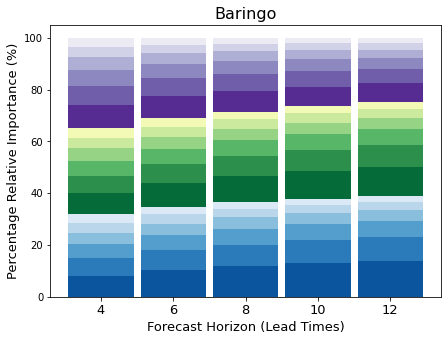

<Figure size 432x288 with 0 Axes>

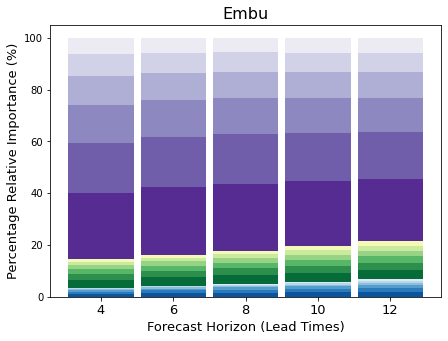

<Figure size 432x288 with 0 Axes>

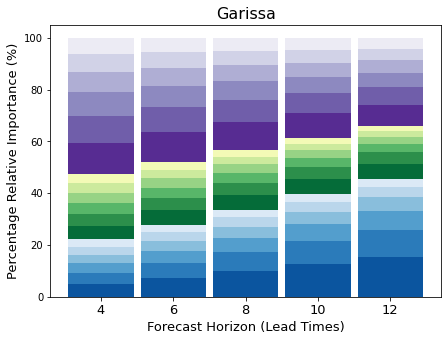

<Figure size 432x288 with 0 Axes>

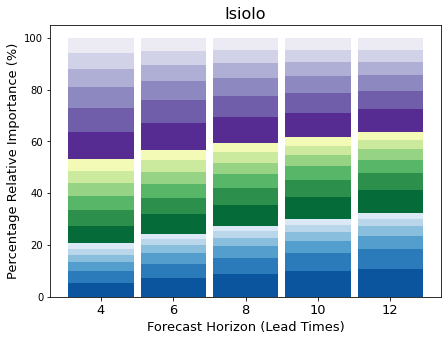

<Figure size 432x288 with 0 Axes>

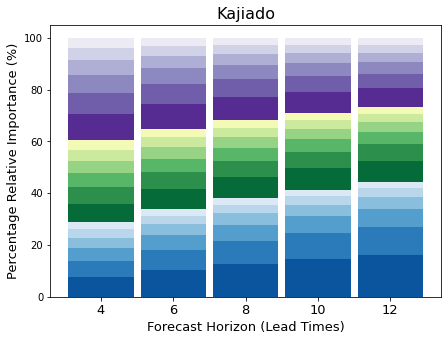

<Figure size 432x288 with 0 Axes>

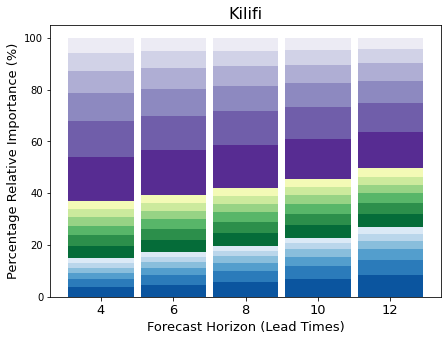

<Figure size 432x288 with 0 Axes>

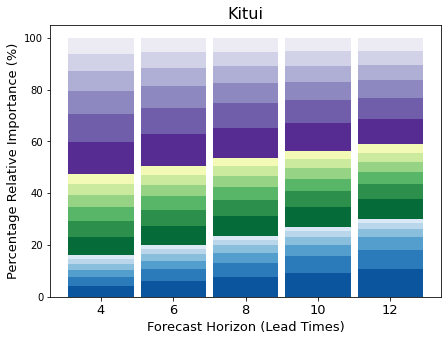

<Figure size 432x288 with 0 Axes>

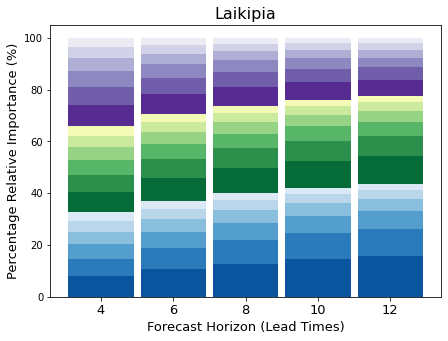

<Figure size 432x288 with 0 Axes>

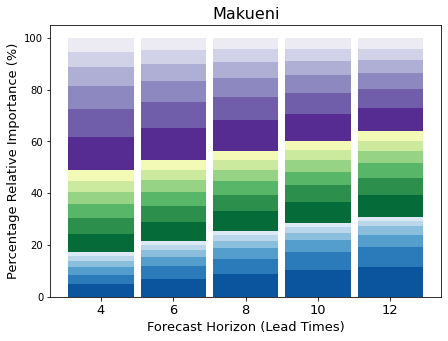

<Figure size 432x288 with 0 Axes>

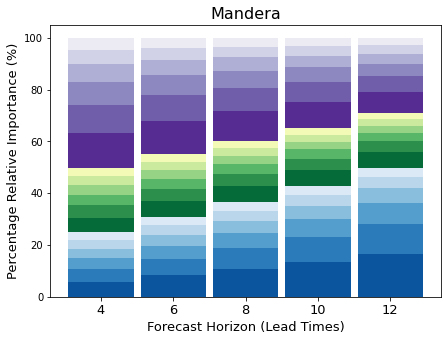

<Figure size 432x288 with 0 Axes>

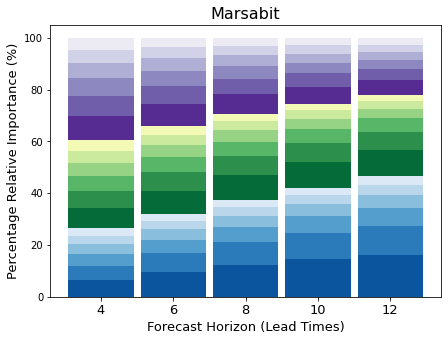

<Figure size 432x288 with 0 Axes>

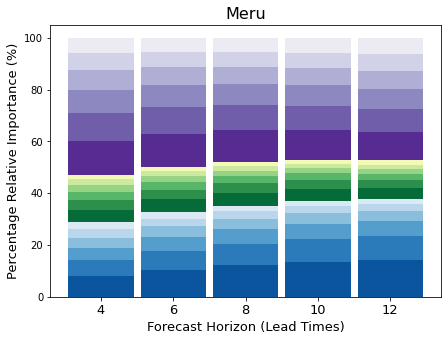

<Figure size 432x288 with 0 Axes>

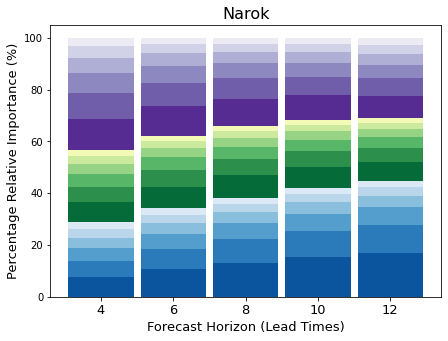

<Figure size 432x288 with 0 Axes>

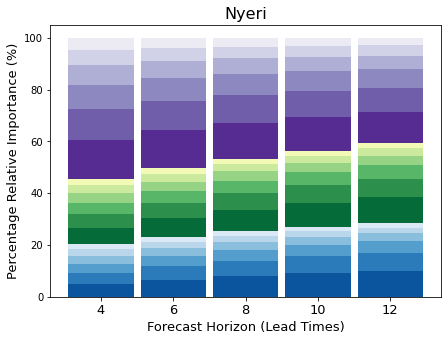

<Figure size 432x288 with 0 Axes>

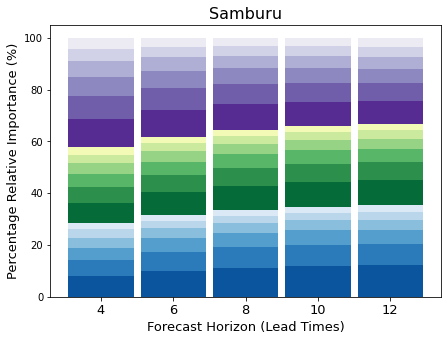

<Figure size 432x288 with 0 Axes>

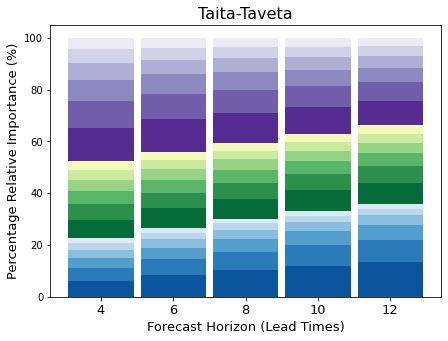

<Figure size 432x288 with 0 Axes>

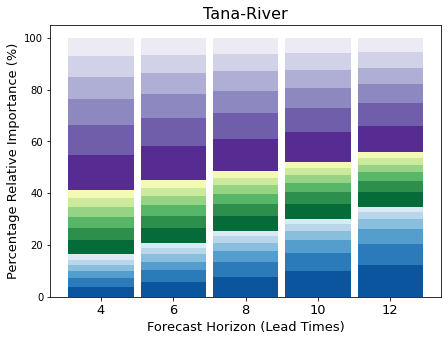

<Figure size 432x288 with 0 Axes>

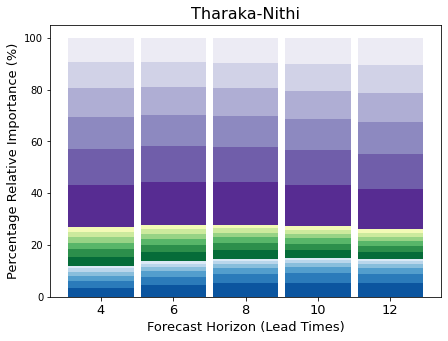

<Figure size 432x288 with 0 Axes>

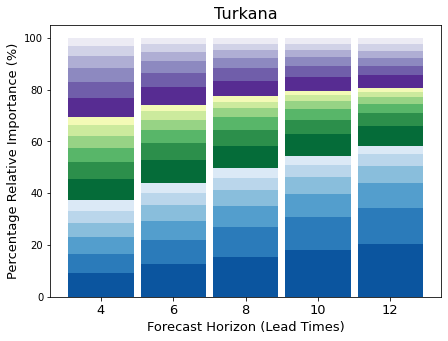

<Figure size 432x288 with 0 Axes>

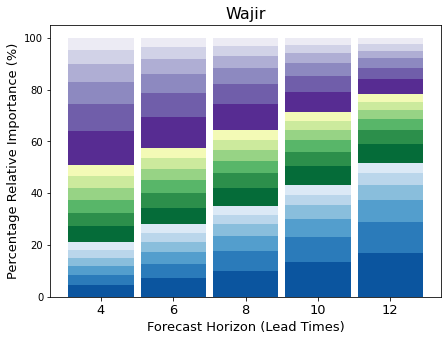

<Figure size 432x288 with 0 Axes>

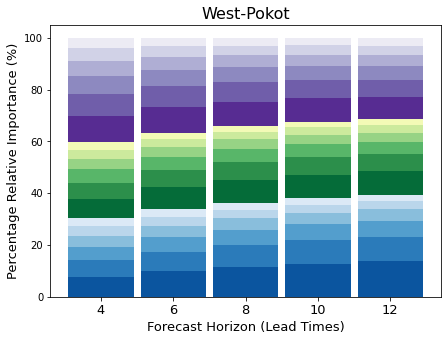

In [272]:
for t in trans2.County.unique():
    sub_county = trans2[trans2.County==t]
    driver_cols = [l[1] for l in sub_county.columns[2:]]
    use_cols = ['Horizon', 'County'] + driver_cols
    sub_county.columns = use_cols
    sub_county = sub_county.set_index('Horizon')
    sub_county = sub_county.iloc[:, 1:].T
    sub_county0 = sub_county.loc[:, ['Horizon_4', 'Horizon_6', 'Horizon_8', 'Horizon_10', 'Horizon_12']]

    plt.figure()
    colors = []
    cmaps = ['Blues_r', 'YlGn_r','Purples_r']
    for c in cmaps:
        colors.extend(sns.color_palette(c, n_colors=6))
    cmap1 = LinearSegmentedColormap.from_list("my_colormap", colors)

    sub_county0.T.plot(kind='bar', stacked=True, width=0.9, figsize=(7,5), cmap=cmap1, legend=False)
    plt.title(t, fontsize=16)
    plt.ylabel('Percentage Relative Importance (%)', fontsize=13)
    plt.xlabel('Forecast Horizon (Lead Times)', fontsize=13)
    plt.xticks(range(0,5), ['4', '6', '8', '10', '12'], fontsize=13, rotation='horizontal')
#     plt.legend(ncol=3, bbox_to_anchor=(1.0, -0.25), loc='center center', fontsize=16)
#     plt.savefig(f'Relimp_{t}.png', dpi=500, bbox_inches='tight')

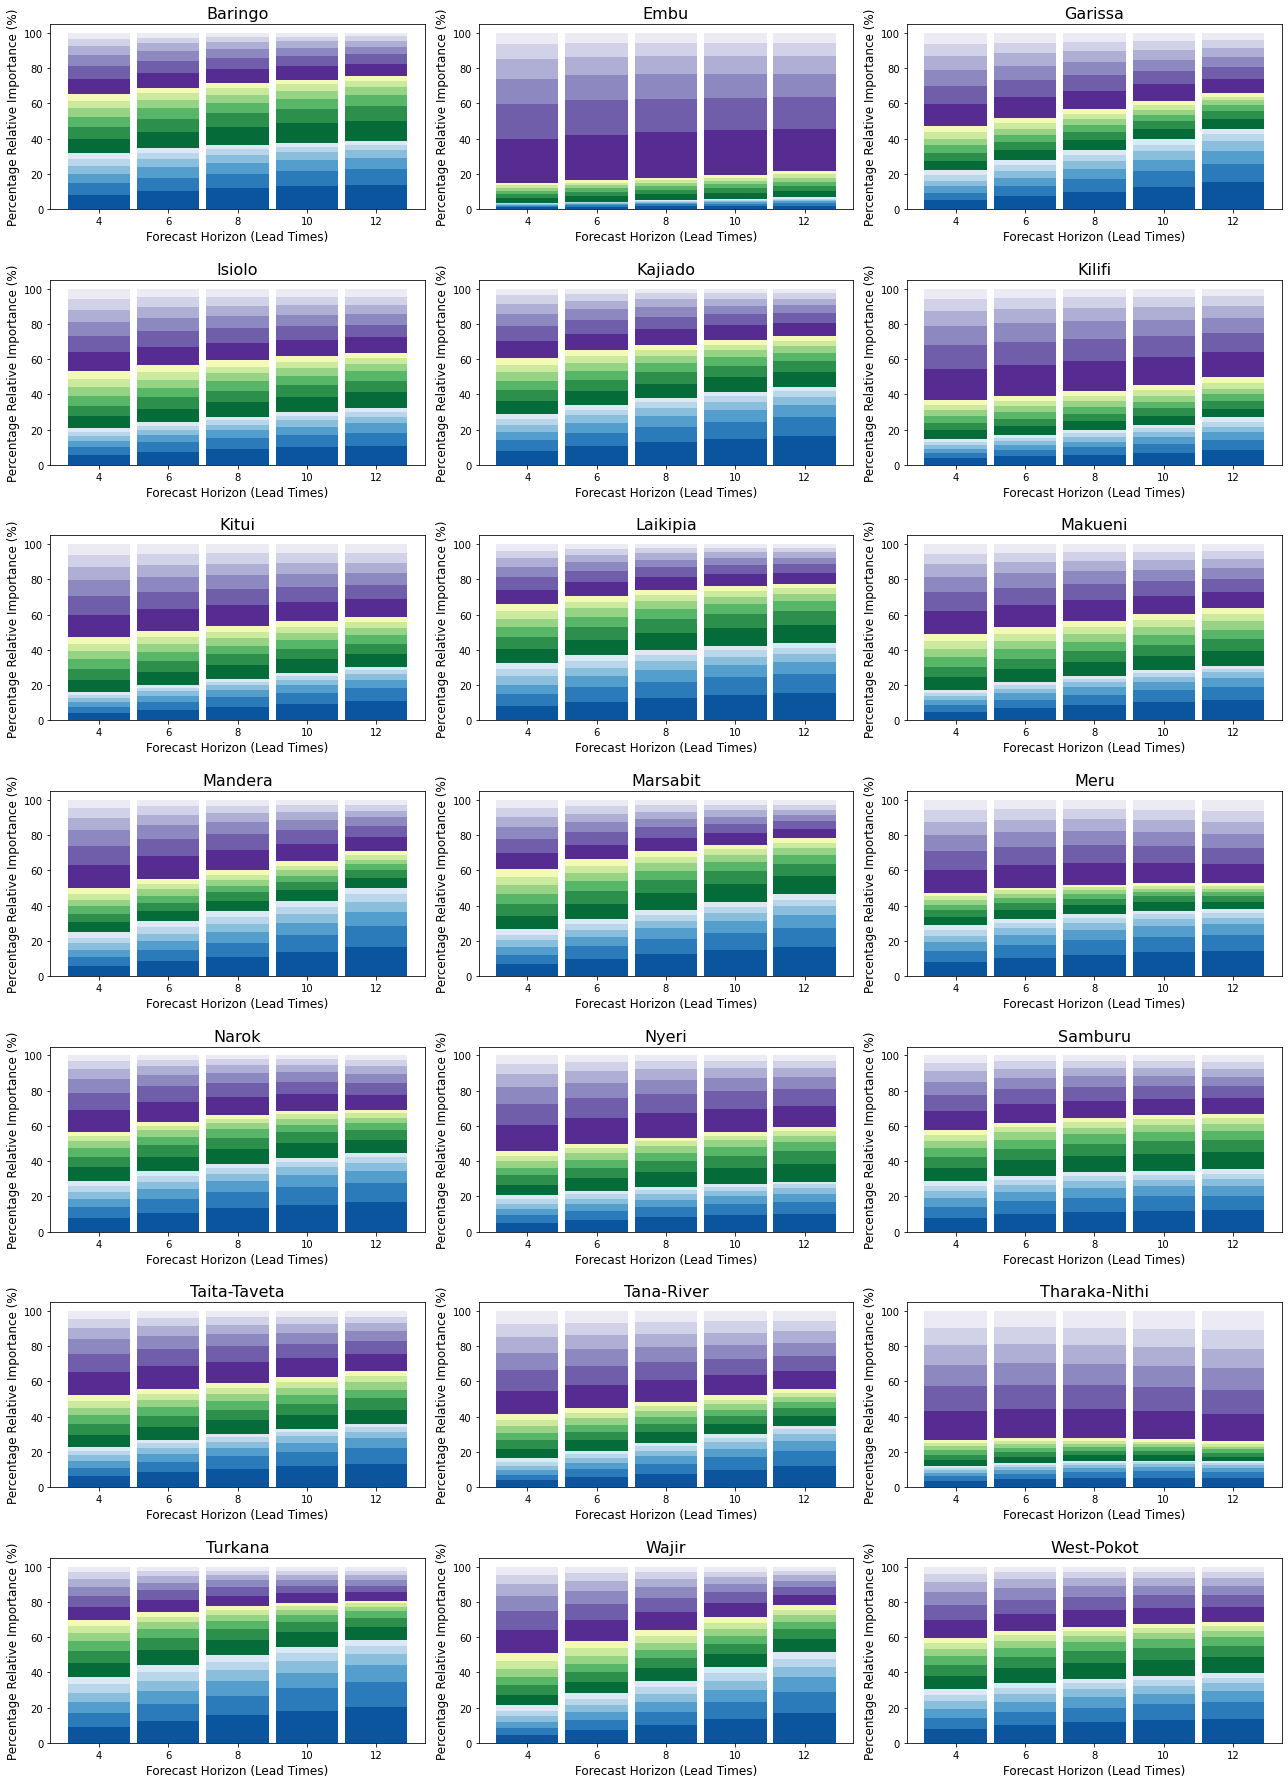

In [408]:
labels2 = ['Precipitation Anomaly Lag0',
 'Precipitation Anomaly Lag1',
 'Precipitation Anomaly Lag2',
 'Precipitation Anomaly Lag3',
 'Precipitation Anomaly Lag4',
 'Precipitation Anomaly Lag5',
 'Soil Moisture Anomaly Lag0',
 'Soil Moisture Anomaly Lag1',
 'Soil Moisture Anomaly Lag2',
 'Soil Moisture Anomaly Lag3',
 'Soil Moisture Anomaly Lag4',
 'Soil Moisture Anomaly Lag5',
 'VCI Lag0',
 'VCI Lag1',
 'VCI Lag2',
 'VCI Lag3',
 'VCI Lag4',
 'VCI Lag5']
fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(18,25))
for a, ax in enumerate(axs.reshape(-1)):
    t = trans2.County.unique()[a]
    sub_county = trans2[trans2.County==t]
    driver_cols = [l[1] for l in sub_county.columns[2:]]
    use_cols = ['Horizon', 'County'] + driver_cols
    sub_county.columns = use_cols
    sub_county = sub_county.set_index('Horizon')
    sub_county = sub_county.iloc[:, 1:].T
    sub_county0 = sub_county.loc[:, ['Horizon_4', 'Horizon_6', 'Horizon_8', 'Horizon_10', 'Horizon_12']]
#     sub_county0.columns = ['4', '6', '8', '10', '12']

    colors = []
    cmaps = ['Blues_r', 'YlGn_r','Purples_r']
    for c in cmaps:
        colors.extend(sns.color_palette(c, n_colors=6))
    cmap1 = LinearSegmentedColormap.from_list("my_colormap", colors)

    sub_county0.T.plot(kind='bar', stacked=True, width=0.9, cmap=cmap1, legend=False, ax=ax)
    ax.set_title(t, fontsize=16)
    ax.set_ylabel('Percentage Relative Importance (%)', fontsize=12)
    ax.set_xlabel('Forecast Horizon (Lead Times)', fontsize=12)
    ax.set_xticklabels(['4', '6', '8', '10', '12'], rotation='horizontal')
    handles, labels = ax.get_legend_handles_labels()
# leg = fig.legend(handles, labels2, ncol=3, loc='center center', bbox_to_anchor=(1.00, -0.1), fontsize=14, fancybox=True, shadow=True)
plt.tight_layout()
#     plt.legend(ncol=3, bbox_to_anchor=(1.0, -0.25), loc='center center', fontsize=16)
fig.savefig('RelImp.pdf', bbox_inches='tight')

In [270]:
df_ls = []
aridscorr_ls = []
saridscorr_ls = []
target = ('VCI', 'Anom')
for v in county1:
    print(v)
    anom_vars_ = ['LST_Anom','Rainfall_Anom', 'SoilMoist_Anom',f'{target[0]}','Season']
    abs_vars = ['LST','Rainfall', 'SoilMoist',f'{target[0]}', 'Season']
    data_df = pd.read_csv(f'NDVI_MinMax3M/Weekly_{v}_SIM_Smooth_Anom_3M.csv')
    data_df['Date']=pd.to_datetime(data_df.Date)
    data_df0 = addSeason(data_df)
#     data_df0 = data_df0[data_df0.County.isin(county1_arid)]
#     print(data_df0)
    if (target[0] == "VCI" and target[1] == "Anom"):
        scale_df1, mean = scaleValuesV(data_df0.loc[:,anom_vars_])
    elif (target[0] == "VCI"  and target[1] == "Abs"):
        scale_df1, mean = scaleValuesV(data_df0.loc[:,abs_vars])
#     elif target == "NDVI":
#         scale_df1, mean = scaleValuesS(data_df0.loc[:,vars_])


    for h in [4,6,8,10,12]:
        X_train, y_train = fcast_train_testDF_AR(scale_df1, p_order0=0,
                                                            p_order1=6, p_order2=6, 
                                                            q_order=6, s_lags=1,target_var=target[0], 
                                                            f_horizon=h)
       
        X_train1 = X_train.loc[:,[ c for c in X_train.columns if 'Season' not in c]]
        corr = X_train1.corr()
        corr0 = corr.loc[:,[ c for c in corr.columns if 'Rainfall' in c]]
        saridscorr_ls.append(corr0.iloc[-1,:])
        
        dep = X_train1.columns.tolist()[-1]
        indep = X_train1.columns.tolist()[:-1]

        df_results = relativeImp(X_train1, outcomeName =dep , driverNames = indep)
        df_results['Horizon'] = np.repeat(f'Horizon_{h}', len(df_results))
        df_results['County'] = np.repeat(v, len(df_results))
        df_ls.append(df_results)
df_results2 = pd.concat(df_ls)

hor = ['driver', 'Horizon_4','Horizon_6','Horizon_8','Horizon_10', 'Horizon_12']
trans = pd.pivot_table(df_results1, values=['normRelaImpt'], columns=['driver'], index=['Horizon'])
trans = trans.T.reset_index()
trans = trans.loc[:, hor]
trans3 = trans.set_index('driver')

Tharaka-Nithi
Turkana
Taita-Taveta
Kajiado
Laikipia
Tana-River
Garissa
Narok
Mandera
Kitui
Wajir
West-Pokot
Isiolo
Kilifi
Meru
Nyeri
Baringo
Makueni
Samburu
Marsabit


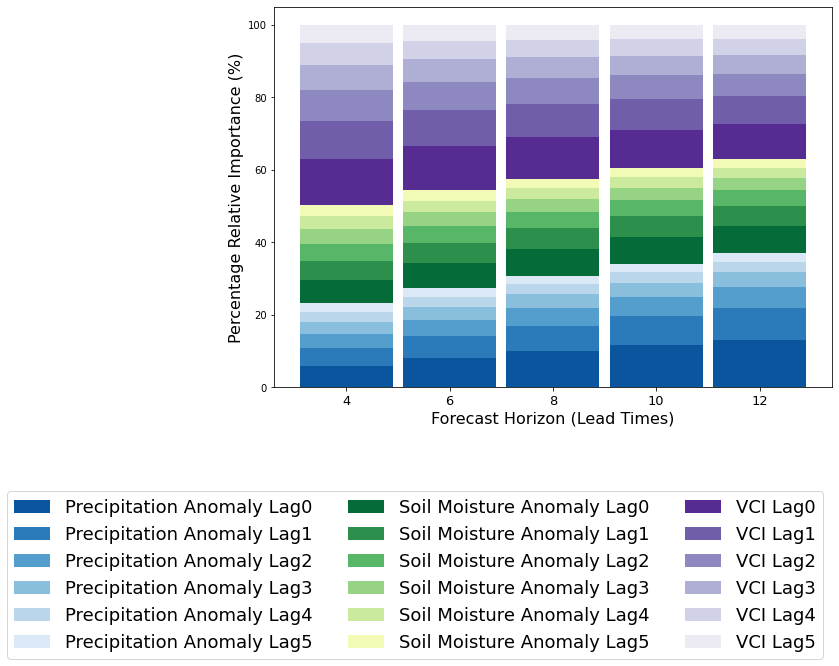

In [406]:
from matplotlib.colors import LinearSegmentedColormap
colors = []

cmaps = ['Blues_r', 'YlGn_r','Purples_r']

if target[1] == 'Anom':
    x = 1.0
else:
    x = 0.98
for c in cmaps:
    colors.extend(sns.color_palette(c, n_colors=6))
cmap1 = LinearSegmentedColormap.from_list("my_colormap", colors)

trans3.T.plot(kind='bar', stacked=True, width=0.9, figsize=(10,7), cmap=cmap1)
plt.ylabel('Percentage Relative Importance (%)', fontsize=16)
plt.xlabel('Forecast Horizon (Lead Times)', fontsize=16)
plt.xticks(range(0,5), ['4', '6', '8', '10', '12'], fontsize=13, rotation='horizontal')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels2, ncol=3, bbox_to_anchor=(x, -0.25), loc='center center', fontsize=18)

plt.savefig(f'total_relimp_{target[0]}-{target[1]}.pdf', dpi=300, bbox_inches='tight')

In [310]:
data_df0

,LST,Rainfall,SoilMoist,NDVI,RCI,TCI,VHI,MTCI,SMCI,VCI,Rainfall_Anom,SoilMoist_Anom,LST_Anom,NDVI_Anom,County,County_Code,Month,Season
28,40.896248,0.324448,0.122356,0.164149,10.194850,56.655177,33.655227,62.173481,27.629071,32.460778,-0.582847,-0.004604,0.823960,-0.009203,Marsabit,10,10,ond
29,42.327119,0.607512,0.121054,0.163797,9.788079,57.042281,33.068250,64.096335,25.811835,32.749484,-0.823837,-0.006864,1.830498,-0.008647,Marsabit,10,10,ond
30,42.304738,1.219186,0.120837,0.162882,9.706036,55.956736,32.573238,65.092164,24.269755,32.375281,-0.991498,-0.009413,1.551864,-0.008875,Marsabit,10,10,ond
31,41.836937,2.154490,0.122184,0.161604,10.001550,54.148756,32.178540,65.069050,23.389295,31.409757,-1.050973,-0.011777,0.967956,-0.010015,Marsabit,10,10,ond
32,41.535541,3.250790,0.125210,0.160324,10.507716,52.258204,31.893202,64.130526,23.253675,30.070393,-1.073799,-0.013600,0.671486,-0.012104,Marsabit,10,11,ond
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923,39.123141,6.364085,0.172375,0.199312,15.677914,45.841130,55.012561,43.851434,52.995366,57.163880,-2.155823,0.010777,-0.849835,0.010497,Marsabit,10,12,ond
924,38.985008,7.694997,0.176516,0.199740,17.211122,45.537943,51.590045,45.790935,51.157752,52.875873,-1.648155,0.009807,-0.676323,0.004359,Marsabit,10,12,ond
925,38.864271,9.072779,0.180350,0.201491,18.695353,45.376458,48.286468,47.657523,49.386360,48.631010,-0.920191,0.009189,-0.510068,-0.000774,Marsabit,10,12,ond
926,38.731333,10.126382,0.183193,0.204270,19.528745,45.531875,45.166282,49.459816,47.525282,44.505188,-0.246610,0.008576,-0.379369,-0.004872,Marsabit,10,12,ond


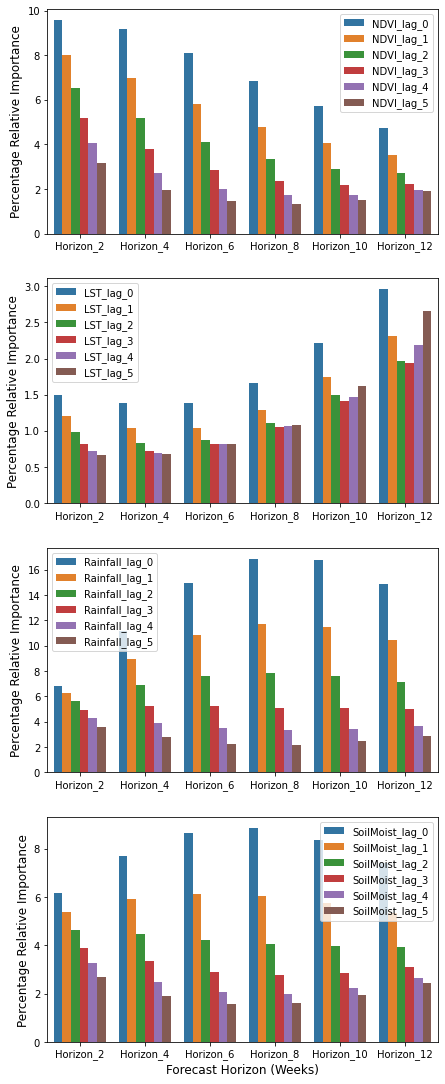

In [968]:
colors = cc.glasbey_bw_minc_20_maxl_70[10:]
fig, axs = plt.subplots(nrows=4,ncols=1, figsize=(7,19))
for l, ax in enumerate(axs.reshape(-1)):
    v=[f'{target}','LST','Rain','Soil'][l]
    sub = neo_df[neo_df['driver'].str.startswith(v)]
    sns.barplot(x='horizon', y="values", hue='driver', data=sub, ci=None, ax=ax)
    ax.set_ylabel('Percentage Relative Importance', fontsize=12)
    ax.set_xlabel('')
    if v == 'Soil':
        ax.set_xlabel('Forecast Horizon (Weeks)', fontsize=12)
    ax.legend(loc='best', fontsize=10)
plt.savefig(f'total_relimp_{target}.pdf', dpi=300)

In [59]:
metricsRVCIw, data15 = runARDL(lst_p0=6,precip_p1=6,soil_p2=6,targ_q=6,data_level='Weekly',season_adjust=False, target='NDVI_Anom', vars_='abs', algo='lr')
metricsAVCIw, data16 = runARDL(lst_p0=0,precip_p1=6,soil_p2=6,targ_q=6,data_level='Weekly',season_adjust=False, target='NDVI_Anom', vars_='abs', algo='lr')
metricsNDAo, data17 = runAR_Adam(target='NDVI_Anom')

Tharaka-Nithi
Index(['NDVI_Anom_lag_0', 'NDVI_Anom_lag_1', 'NDVI_Anom_lag_2',
       'NDVI_Anom_lag_3', 'NDVI_Anom_lag_4', 'NDVI_Anom_lag_5', 'LST_lag_0',
       'LST_lag_1', 'LST_lag_2', 'LST_lag_3', 'LST_lag_4', 'LST_lag_5',
       'Rainfall_lag_0', 'Rainfall_lag_1', 'Rainfall_lag_2', 'Rainfall_lag_3',
       'Rainfall_lag_4', 'Rainfall_lag_5', 'SoilMoist_lag_0',
       'SoilMoist_lag_1', 'SoilMoist_lag_2', 'SoilMoist_lag_3',
       'SoilMoist_lag_4', 'SoilMoist_lag_5'],
      dtype='object')
[ 3. -2. -1.  1.  1. -0. -0.  0. -0.  0.  0. -0. -0.  0. -0.  0.  0. -0.
  0. -0. -0.  0. -0.  0.]
Index(['NDVI_Anom_lag_0', 'NDVI_Anom_lag_1', 'NDVI_Anom_lag_2',
       'NDVI_Anom_lag_3', 'NDVI_Anom_lag_4', 'NDVI_Anom_lag_5', 'LST_lag_0',
       'LST_lag_1', 'LST_lag_2', 'LST_lag_3', 'LST_lag_4', 'LST_lag_5',
       'Rainfall_lag_0', 'Rainfall_lag_1', 'Rainfall_lag_2', 'Rainfall_lag_3',
       'Rainfall_lag_4', 'Rainfall_lag_5', 'SoilMoist_lag_0',
       'SoilMoist_lag_1', 'SoilMoist_lag_2', 'S

Text(0.5, 42.0, 'Forecast Horizons')

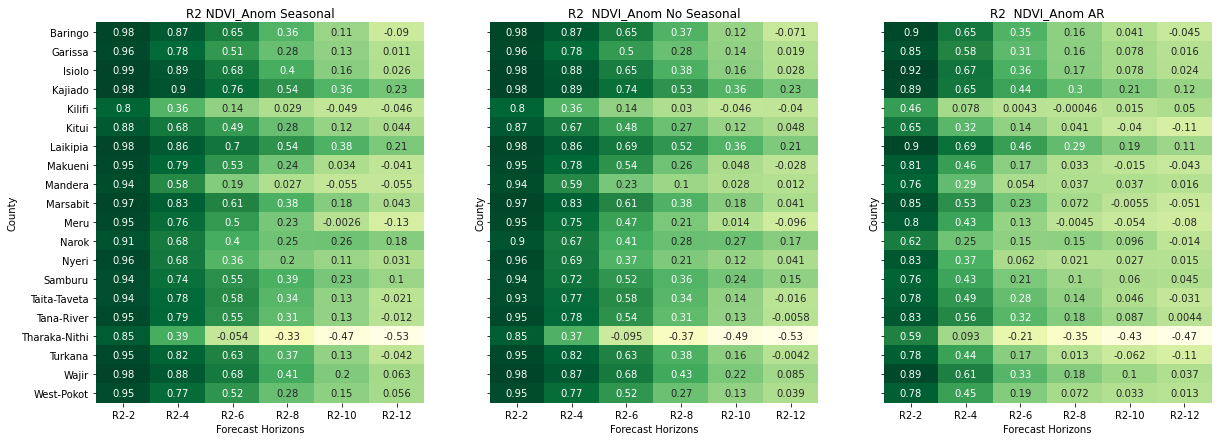

In [60]:
piv19 = pd.pivot_table(metricsRVCIw[metricsRVCIw['Horizon']>=2], columns=['Horizon'], index=['County'], values=['R2'])
piv20 = pd.pivot_table(metricsAVCIw[metricsAVCIw['Horizon']>=2], columns=['Horizon'], index=['County'], values=['R2'])
piv21 = pd.pivot_table(metricsNDAo[metricsNDAo['Horizon']>=2], columns=['Horizon'], index=['County'], values=['R2'])

# piv10.to_csv('R2_NDVI3M_Only.csv')
# piv11.to_csv('R2_NDVI3M_Plus_LPS.csv')
# piv12 = piv11-piv10
# piv12.to_csv('Change_R2_NDVI3M_Plus.csv')
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 7), sharey=True)


ax[0].set_title('R2 NDVI_Anom Seasonal')
sns.heatmap(piv19, annot=True, cmap='YlGn', cbar=False, ax=ax[0])
ax[0].set_xlabel('Forecast Horizons')


ax[1].set_title('R2  NDVI_Anom No Seasonal')
sns.heatmap(piv20, annot=True, cmap='YlGn', cbar=False, ax=ax[1])
ax[1].set_xlabel('Forecast Horizons')


ax[2].set_title('R2  NDVI_Anom AR')
sns.heatmap(piv21, annot=True, cmap='YlGn', cbar=False, ax=ax[2])
ax[2].set_xlabel('Forecast Horizons')

# plt.savefig('NDVI3M-VCI_with_interxn.png')

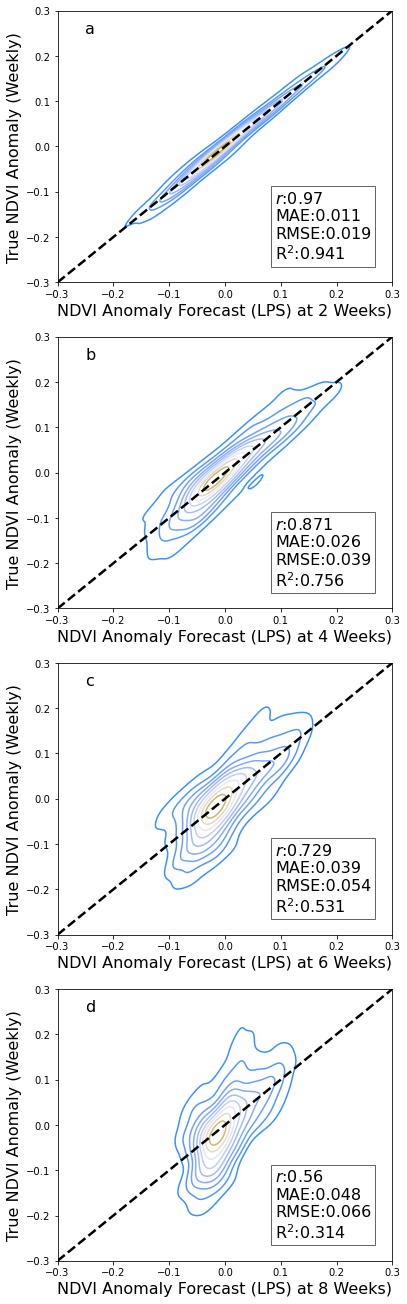

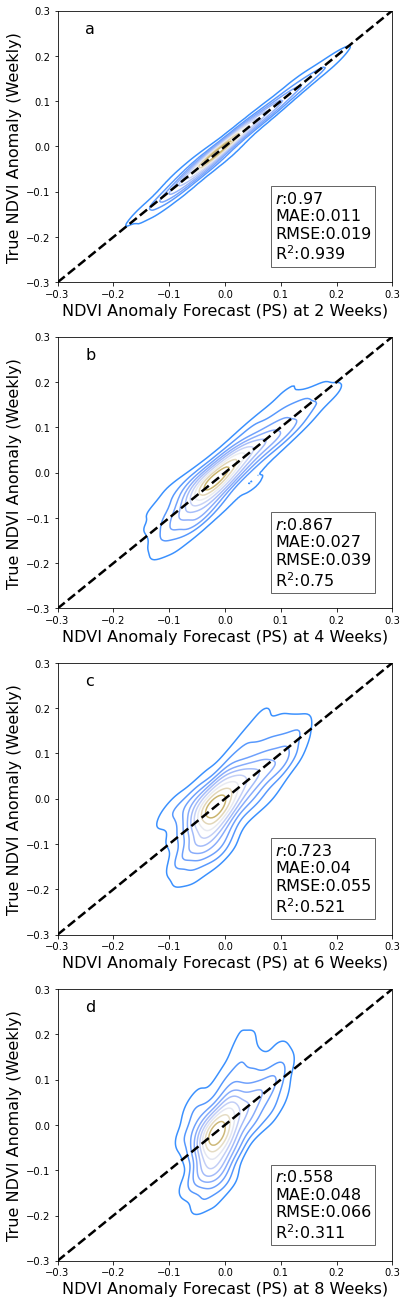

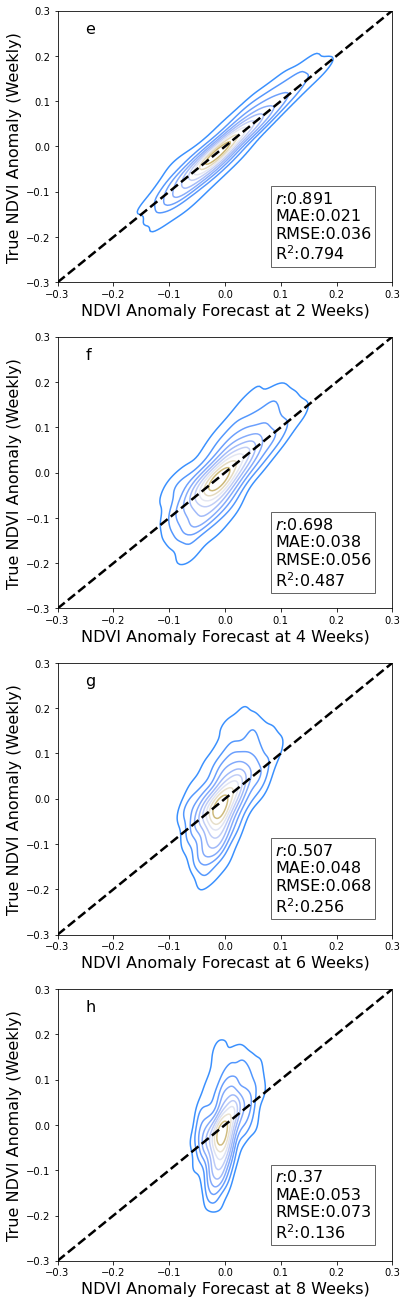

In [66]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(6, 23))
for a, ax in enumerate(axs.reshape(-1)):
    i  = [2,4,6,8][a]
    t  = ['a','b','c','d'][a]
    hor = data15[data15['Horizon']==i]
    
    corr = hor.iloc[:,2:].corr().values
    mae2 = mean_absolute_error(hor.Observed.values, hor.Predicted.values)
    rmse2 = np.sqrt(mean_squared_error(hor.Observed.values, hor.Predicted.values))
    r2 = r2_score(hor.Observed.values, hor.Predicted.values)
    
    sns.kdeplot(hor["Predicted"], hor["Observed"], cmap=cc.cm.bwy, thresh=0.1, ax=ax)
    ax.set_ylabel('True NDVI Anomaly (Weekly)', fontsize=16)
    ax.set_xlabel(f'NDVI Anomaly Forecast (LPS) at {i} Weeks)', fontsize=16)
    ax.set_xlim(-0.3,0.3)
    ax.set_ylim(-0.3,0.3)
    ax.plot((-0.3,0.3), (-0.3,0.3), 'k--', lw=2.5)
    ax.annotate(t, (-0.25,0.25) , fontsize=16)
    txt = ax.text(x=0.09, y=-0.25, s=f'$r$:{corr[0,1].round(3)}\nMAE:{mae2.round(3)}\nRMSE:{rmse2.round(3)}\nR$^2$:{r2.round(3)}', fontsize=16)
    txt.set_bbox(dict(facecolor='white', alpha=0.6))
# fig.suptitle('B')
plt.savefig(f'ARDL_Scatter_Anom-LSP.pdf', dpi=300)
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(6, 23))
for a, ax in enumerate(axs.reshape(-1)):
    i  = [2,4,6,8][a]
    t  = ['a','b','c','d'][a]
    hor = data16[data16['Horizon']==i]
    
    corr = hor.iloc[:,2:].corr().values
    mae2 = mean_absolute_error(hor.Observed.values, hor.Predicted.values)
    rmse2 = np.sqrt(mean_squared_error(hor.Observed.values, hor.Predicted.values))
    r2 = r2_score(hor.Observed.values, hor.Predicted.values)
    
    sns.kdeplot(hor["Predicted"], hor["Observed"], cmap=cc.cm.bwy, thresh=0.1, ax=ax)
    ax.set_ylabel('True NDVI Anomaly (Weekly)', fontsize=16)
    ax.set_xlabel(f'NDVI Anomaly Forecast (PS) at {i} Weeks)', fontsize=16)
    ax.set_xlim(-0.3,0.3)
    ax.set_ylim(-0.3,0.3)
    ax.plot((-0.3,0.3), (-0.3,0.3), 'k--', lw=2.5)
    ax.annotate(t, (-0.25,0.25) , fontsize=16)
    txt = ax.text(x=0.09, y=-0.25, s=f'$r$:{corr[0,1].round(3)}\nMAE:{mae2.round(3)}\nRMSE:{rmse2.round(3)}\nR$^2$:{r2.round(3)}', fontsize=16)
    txt.set_bbox(dict(facecolor='white', alpha=0.6))
# fig.suptitle('B')
plt.savefig(f'ARDL_Scatter_Anom-SP.pdf', dpi=300)
# plt.subplot(321)
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(6, 23))
for a, ax in enumerate(axs.reshape(-1)):
    i  = [2,4,6,8][a]
    t  = ['e','f','g','h'][a]
    hor = data17[data17['Horizon']==i]
    
    corr = hor.iloc[:,2:].corr().values
    mae2 = mean_absolute_error(hor.Observed.values, hor.Predicted.values)
    rmse2 = np.sqrt(mean_squared_error(hor.Observed.values, hor.Predicted.values))
    r2 = r2_score(hor.Observed.values, hor.Predicted.values)
    
    sns.kdeplot(hor["Predicted"], hor["Observed"], cmap=cc.cm.bwy, thresh=0.1, ax=ax)
    ax.set_ylabel('True NDVI Anomaly (Weekly)', fontsize=16)
    ax.set_xlabel(f'NDVI Anomaly Forecast at {i} Weeks)', fontsize=16)
    ax.set_xlim(-0.3,0.3)
    ax.set_ylim(-0.3,0.3)
    ax.plot((-0.3,0.3), (-0.3,0.3), 'k--', lw=2.5)
    ax.annotate(t, (-0.25,0.25) , fontsize=16)
    txt = ax.text(x=0.09, y=-0.25, s=f'$r$:{corr[0,1].round(3)}\nMAE:{mae2.round(3)}\nRMSE:{rmse2.round(3)}\nR$^2$:{r2.round(3)}', fontsize=16)
    txt.set_bbox(dict(facecolor='white', alpha=0.6))
# fig.suptitle('B')
plt.savefig(f'AR_Scatter_Anom-Only.pdf', dpi=300)

In [64]:
df_ls = []
target = 'NDVI_Anom'
for v in county1:
    print(v)
    vars_ = ['LST', 'Rainfall','SoilMoist',f'{target}','Season']
    data_df = pd.read_csv(f'NDVI_Anom/Weekly_{v}_SIM_Smooth_anom.csv')
    data_df['Date']=pd.to_datetime(data_df.Date)
    data_df0 = addSeason(data_df)
    if target == "VCI":
        scale_df1, mean = scaleValuesV(data_df0.loc[:,vars_])
    elif target == "NDVI":
        scale_df1, mean = scaleValuesS(data_df0.loc[:,vars_])
    elif target == "NDVI_Anom":
        scale_df1 = scaleValuesA(data_df0.loc[:,vars_])

    for h in [2,4,6,8]:
        X_train, y_train = fcast_train_testDF_AR(scale_df1, p_order0=6,
                                                            p_order1=6, p_order2=6, 
                                                            q_order=6, s_lags=1,target_var=target, 
                                                            f_horizon=h)
        X_train1 = X_train.loc[:,[ c for c in X_train.columns if 'Season' not in c]]

        dep = X_train1.columns.tolist()[-1]
        indep = X_train1.columns.tolist()[:-1]

        df_results = relativeImp(X_train1, outcomeName =dep , driverNames = indep)
        df_results['Horizon'] = np.repeat(f'Horizon_{h}', len(df_results))
        df_results['County'] = np.repeat(v, len(df_results))
        df_ls.append(df_results)
df_results1 = pd.concat(df_ls)

hor = ['driver', 'Horizon_2','Horizon_4','Horizon_6','Horizon_8']
trans = pd.pivot_table(df_results1, values=['normRelaImpt'], columns=['driver'], index=['Horizon'])
trans = trans.T.reset_index()
trans = trans.loc[:, hor]
trans1 = trans.set_index('driver')

st_ls = []
for h in hor[1:]:
    neo = trans.loc[:,['driver']]
    neo['values'] = trans[h].values
    neo['horizon'] = h
    st_ls.append(neo)
neo_df = pd.concat(st_ls)

Tharaka-Nithi
Turkana
Taita-Taveta
Kajiado
Laikipia
Tana-River
Garissa
Narok
Mandera
Kitui
Wajir
West-Pokot
Isiolo
Kilifi
Meru
Nyeri
Baringo
Makueni
Samburu
Marsabit


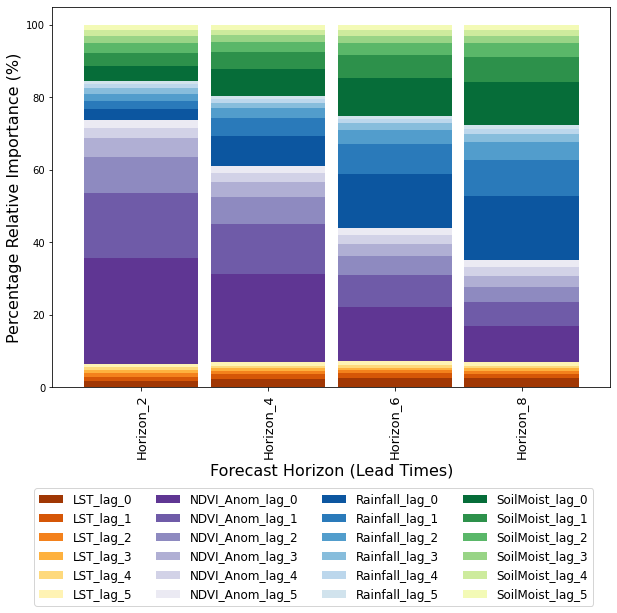

In [65]:
colors = []
cmaps = ['YlOrBr_r', 'Purples_r', 'Blues_r','YlGn_r']
# 'YlGn_r'
for c in cmaps:
    colors.extend(sns.color_palette(c, n_colors=6))
cmap1 = LinearSegmentedColormap.from_list("my_colormap", colors)

trans1.T.plot(kind='bar', stacked=True, width=0.9, figsize=(10,7), cmap=cmap1)
plt.ylabel('Percentage Relative Importance (%)', fontsize=16)
plt.xlabel('Forecast Horizon (Lead Times)', fontsize=16)
plt.xticks( fontsize=13)
plt.xticks( fontsize=13)
plt.legend(ncol=4, bbox_to_anchor=(0.98, -0.25), loc='right center', fontsize=12)
plt.savefig(f'total_relimp_{target}_Anom.pdf', dpi=300, bbox_inches='tight')